# London Tube
Simon Schmetz - Paola Carolina Suarez  
Network Analysis  
Master in Statistics for Data Science  
Universidad Carlos III de Madrid  

Data Source: https://github.com/jaron/railgraph

## Introduction

The "London Underground Network" refers to the metro system of London, UK, encompassing its stations and the connections between them. The network consists of 309 vertices (representing stations), and 370 edges (representing the metro line connections between stations). Notably, multiple metro lines can connect to the same station, resulting in multiple edges. As an undirected network, each edge signifies a bidirectional connection, meaning travel is possible in both directions between stations.



## Data loading and cleanning

We beginn by loading the Network and enriching the nodes with usage data from a seperate dataset.

In [37]:
# Load Libraries 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx


We begin by loading the Network and extracting the labels of the Stations for later Use.

In [38]:
#Read the Network
G = nx.read_graphml('data/london_tube/tubeDLR.graphml')

# Extract labels from node data
labels = nx.get_node_attributes(G, 'label')

# get node position seperately
pos_geo = {node: (float(data['longitude']), float(data['latitude'])) for node, data in G.nodes(data=True)}


We remove node attributes that were delivered with the network.

In [39]:
# List of attributes to remove
attributes_to_remove = [
    'Betweenness Centrality', 'Closeness Centrality', 'Clustering Coefficient', 
    'Degree', 'Eccentricity', 'Eigenvector Centrality', 'In-Degree', 
    'Number of triangles', 'Out-Degree', 'PageRank', 'b','g',
    'latitude_copy', 'longitude_copy', 'r', 'size', 'x', 'y','displyName'
]

# Remove the attributes from each node
for node, data in G.nodes(data=True):
    for attr in attributes_to_remove:
        data.pop(attr, None)

To further enrich our Network, we take a seperate Dataset that contains average entry and exit values from most of the stations in our Network and add theses to our nodes. To do so, we first remove all stations for which no numbers are available, which as it turns our all correspond to the Docklands Light Railway (DLR) and thus can be knowingly discarded.

In [40]:
### Add Usage Data

usage_data = pd.read_csv('data/london_tube/2017_Entry_Exit.csv')

# Feature Engineering
usage_data['Avg_Exit_Weekend'] = usage_data[['Exit_Saturday', 'Exit_Sunday']].mean(axis=1)
usage_data['Avg_Entry_Weekend'] = usage_data[['Entry_Saturday', 'Entry_Sunday']].mean(axis=1)

usage_data.drop(columns=['Entry_Saturday', 'Entry_Sunday', 'Exit_Saturday', 'Exit_Sunday','Note','Borough','AnnualEntryExit_Mill'], inplace=True)

# Define mapping from non-standard to standard names
station_name_corrections = {
    'Edgware Road (Cir)': 'Edgware Road',
    'Kew Gardens': 'Kew Gardens (London)',
    "Shepherd's Bush (H&C)": "Shepherd's Bush Market",
    "Shepherd's Bush (Cen)": "Shepherd's Bush",
    'Hammersmith (Dis)': 'Hammersmith (Piccadilly and District lines)',
    'Hammersmith (H&C)': 'Hammersmith (Hammersmith & City and Circle lines)',
    "St. John's Wood": "St John's Wood",
    'Bank & Monument': 'Bank-Monument',
    'Totteridge & Whetstone': 'Totteridge and Whetstone',
    'Paddington': 'London Paddington',
    'Richmond': 'Richmond (London)',
    'Heathrow Terminals 123': 'Heathrow Terminals 1, 2, 3',
    'Edgware Road (Bak)': 'Edgware Road (Bakerloo line)',
    'Victoria': 'London Victoria'
}

# Apply corrections to df.Stations
usage_data['Station'] = usage_data['Station'].replace(station_name_corrections)


# Filter nodes in the graph that are available in usage_data
stations_in_usage_data = set(usage_data['Station'])
nodes_to_keep = [node for node, data in G.nodes(data=True) if data.get('label') in stations_in_usage_data]

# Identify stations to be dropped
stations_to_drop = [labels[node] for node, data in G.nodes(data=True) if data.get('label') not in stations_in_usage_data]



# Create a subgraph with only the nodes to keep
G = G.subgraph(nodes_to_keep).copy()

# Add Entry_Week, Exit_Week, Avg_Exit_Weekend, Avg_Entry_Weekend to the attributes of the remaining nodes
for node, data in G.nodes(data=True):
    station_label = data.get('label')
    if station_label in stations_in_usage_data:
        station_data = usage_data[usage_data['Station'] == station_label].iloc[0]
        data['Entry_Week'] = station_data['Entry_Week']
        data['Exit_Week'] = station_data['Exit_Week']
        data['Avg_Exit_Weekend'] = station_data['Avg_Exit_Weekend']
        data['Avg_Entry_Weekend'] = station_data['Avg_Entry_Weekend']

        # Remove edges connected to nodes that are not in the filtered graph
        G.remove_edges_from([(u, v) for u, v in G.edges() if u not in nodes_to_keep or v not in nodes_to_keep])


Then is added the Euclidean Distance between Nodes as a attribute of the arcs using longitude/latitude of the nodes.

In [41]:
# Add "dist" attribute to each edge based on the euclidean distance between nodes in kilometers
for u, v, data in G.edges(data=True):
    lon1, lat1 = pos_geo[u]
    lon2, lat2 = pos_geo[v]
    distance = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2) * 111  # Convert radiants to kilometers
    data['dist'] = distance

This yields us the Network with the following attributes of nodes and edges.

In [42]:
# Attributes

# Nodes
unique_keys = set().union(*(data.keys() for _, data in G.nodes(data=True)))
print("Unique Node Attributes:")
for key in sorted(unique_keys):
    print(f" - {key}")

# Edges
unique_edge_keys = set().union(*(data.keys() for _, _, data in G.edges(data=True)))
print("\nUnique Edge Attributes:")
for key in sorted(unique_edge_keys):
    print(f" - {key}")

Unique Node Attributes:
 - Avg_Entry_Weekend
 - Avg_Exit_Weekend
 - Entry_Week
 - Exit_Week
 - displayName
 - label
 - latitude
 - longitude
 - stationReference

Unique Edge Attributes:
 - Neo4j Relationship Type
 - dist
 - line
 - weight


## Utils functions

In [43]:
def plot_shortest_path(G, start_id, stop_id):

    # Calculate the shortest path
    try:
        shortest_path = nx.dijkstra_path(G, source=start_id, target=stop_id, weight='dist')
    except nx.NetworkXNoPath:
        print(f"No path exists between {start_id} and {stop_id}.")
        return

    # Extract the edges in the shortest path
    path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))

    # Create a plot
    fig, ax = plt.subplots(figsize=(25, 25))  # More balanced size

    # Set the extent to match London's approximate geographical coordinates
    ax.set_xlim(-0.68, 0.29)
    ax.set_ylim(51.39, 51.73)

    # Ensure the correct aspect ratio
    ax.set_aspect(1 / np.cos(np.radians((51.4 + 51.73) / 2)))  # Adjust for London's latitude

    # Add a basemap
    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=10)

    # Overlay the London Tube Network
    nx.draw(G, pos=pos_geo, with_labels=False, node_size=50, node_color='lightgray', 
            edge_color='lightgray', ax=ax)

    # Highlight the shortest path
    nx.draw_networkx_edges(G, pos=pos_geo, edgelist=path_edges, edge_color='lightblue', width=3, ax=ax)
    nx.draw_networkx_nodes(G, pos=pos_geo, nodelist=shortest_path, node_color='darkblue', node_size=100, ax=ax)

    # Add labels for the start and stop stations
    nx.draw_networkx_labels(G, pos=pos_geo, labels={start_id: labels[start_id], stop_id: labels[stop_id]}, font_size=12, ax=ax)

    # Display the plot
    plt.title(f"Shortest Path from {labels[start_id]} to {labels[stop_id]}")
    plt.show()
    

In [44]:

def plot_highlighted_stations(G, pos_geo, station_nodes, labels):

    # Plot the network
    plt.figure(figsize=(12, 8))

    nx.draw(G, pos=pos_geo, with_labels=False, node_size=10, node_color='lightgray', edge_color='lightgray')
    nx.draw_networkx_nodes(G, pos=pos_geo, nodelist=station_nodes, node_color='purple', node_size=100, label='Highlighted Stations')

    # Add labels for the highlighted stations
    nx.draw_networkx_labels(G, pos=pos_geo, labels={node: labels[node] for node in station_nodes}, font_size=8)

    # Add legend
    plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
    plt.title("London Tube Network with Highlighted Stations")
    plt.show()


## Network properties

We beginn by analysing basic properties of the network to get a general idea of the characteristics of our network. We start by plotting the network with the node position corresponding to the longitude and latitude values onto a map of the City of London to get a general feel for the geography underlying the network. We see how the Network consist out of arms corresponding to the metro lines that meet in the city center at hub stations where changes between lines are possible.

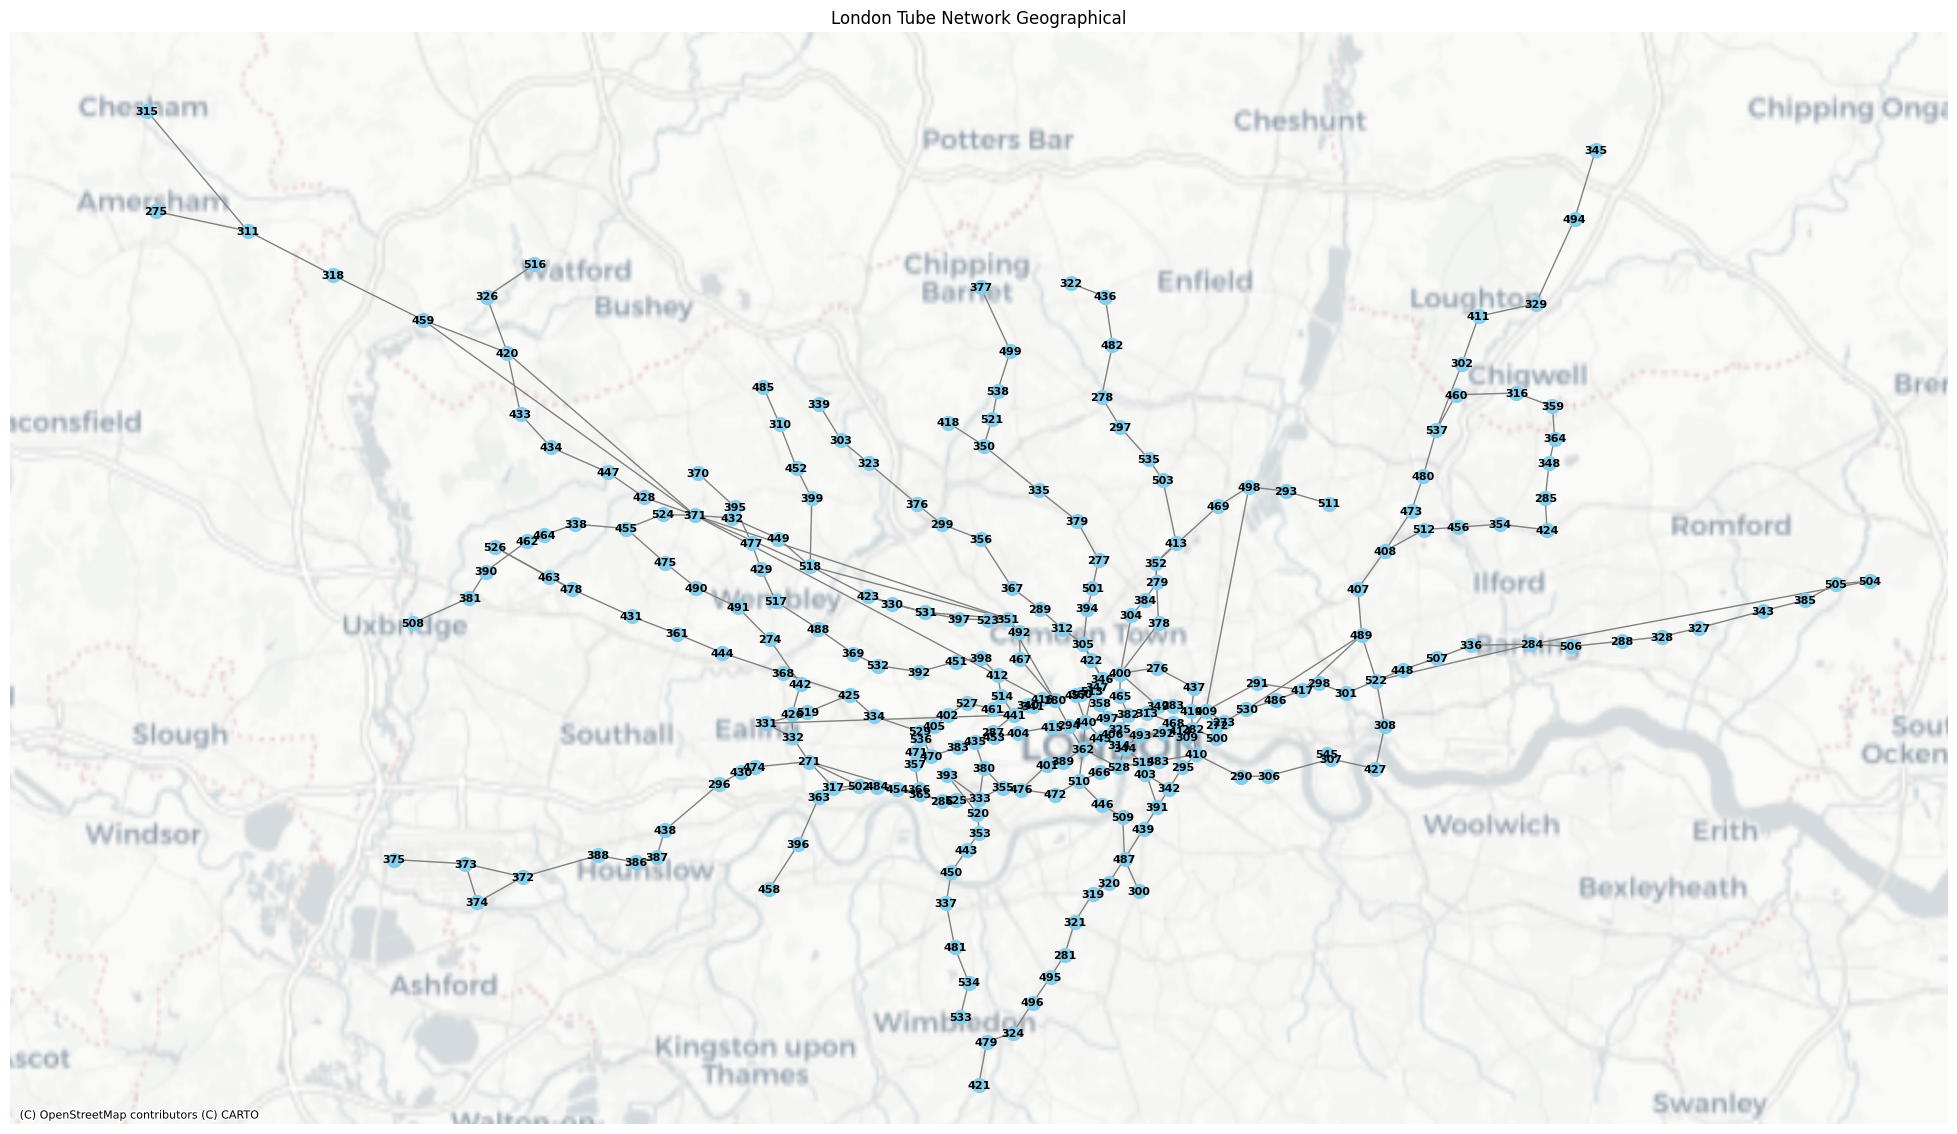

In [45]:
import contextily as ctx
# Create a plot
fig, ax = plt.subplots(figsize=(25, 25))  # More balanced size

# Set the extent to match London's approximate geographical coordinates
ax.set_xlim(-0.68, 0.29)
ax.set_ylim(51.39, 51.73)

# Ensure the correct aspect ratio
ax.set_aspect(1 / np.cos(np.radians((51.4 + 51.73) / 2)))  # Adjust for London's latitude

# Add a basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=10)

# Overlay the London Tube Network
nx.draw(G, pos=pos_geo, with_labels=True, node_size=100, node_color='skyblue', 
        font_size=8, font_weight='bold', edge_color='gray', ax=ax)

# Display the plot
plt.title("London Tube Network Geographical")
plt.show()

We can compare our Network to an official map of the City of London Transportation System and recognize the same tree structure with nodes that connect the trees (lines).

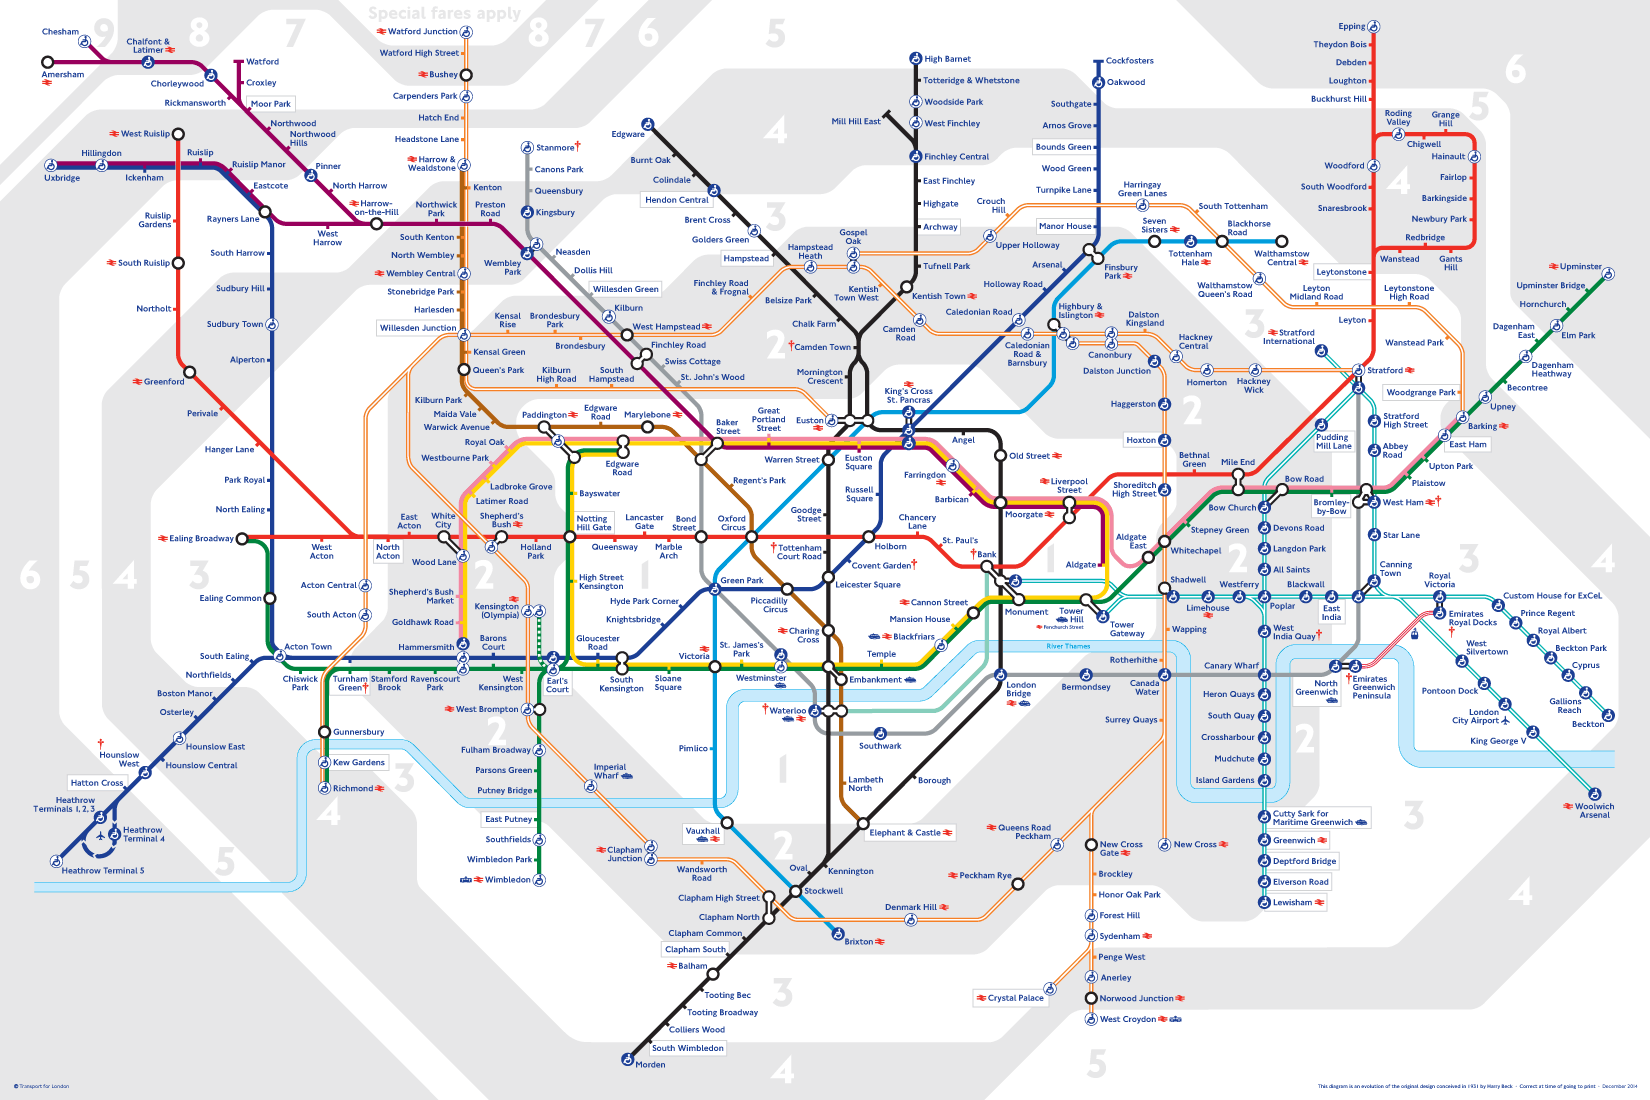

The London Underground metro system, after data cleaning, can be represented as an undirected network with 269 nodes (stations) and 324 edges (connections between stations).

In [46]:
# Check if the graph is directed
if isinstance(G, nx.DiGraph):
    print("The graph is directed.")
else:
    print("The graph is undirected.")


#Count nodes
print("Number of Nodes (Order):", G.number_of_nodes())

#Count edges
print("Number of Edges:", len(G.edges(data=True)))


The graph is undirected.
Number of Nodes (Order): 269
Number of Edges: 324


Then, it is checked if there are any isolated vertices (stations) in the network.It is found the isolated vertex '545' in the London Underground network, whichc refers to a station that has no connections to any other stations, making it unreachable within the system. In this case, the isolated station is produced as a error of the initial enrichment of with usage data wich left the node isolated. We thus delete the node to correct for that error.

In [47]:
# Find isolated vertices
print("Isolated Vertices: ",list(nx.isolates(G)))

print(labels["545"])

# Remove node '545' from labels and the graph
labels.pop("545", None)
G.remove_node("545")

print("Isolated Vertices: ",list(nx.isolates(G)))

Isolated Vertices:  ['545']
Canary Wharf
Isolated Vertices:  []


In network analysis, specifically in the context of the London Underground metro system, it's important to identify adjacent vertices (stations) and edges (metro lines). This helps to understand the connections between stations and the metro lines serving them. The following code allows us to find these adjacent vertices, revealing the connections between different metro lines at a given station. Additionally, the adjacent edges provide information about possible line changes that a station can offer, indicating where passengers can switch between different metro lines.

In [48]:

# Get the adjacent vertices
chosen_vertex = '487'

adjacent_vertices = list(G.neighbors(chosen_vertex))
print(f"Adjacent vertices of vertex {chosen_vertex}: {adjacent_vertices}")

# Print the labels of the adjacent vertices
adjacent_labels = [labels[vertex] for vertex in adjacent_vertices]
print(f"Adjacent vertices of vertex {labels[chosen_vertex]}: {adjacent_labels}")

Adjacent vertices of vertex 487: ['300', '320', '439', '509']
Adjacent vertices of vertex Stockwell: ['Brixton', 'Clapham North', 'Oval', 'Vauxhall']


In [49]:
# Get the adjacent edges (edges that involve the chosen vertex)
adjacent_edges = G.edges(chosen_vertex)
print(f"Adjacent edges of vertex {chosen_vertex}: {adjacent_edges}")

# Print the details of the adjacent edges, including the metro line (edge attribute)
for edge in adjacent_edges:
    # Assuming the edge attribute 'line' stores the metro line's name
    line_name = G[edge[0]][edge[1]].get('line', 'Unknown Line')  # Default to 'Unknown Line' if not available
    print(f"Edge: {edge} (Connecting {labels[edge[0]]} and {labels[edge[1]]}) - Metro Line: {line_name}")

Adjacent edges of vertex 487: [('487', '300'), ('487', '320'), ('487', '439'), ('487', '509')]
Edge: ('487', '300') (Connecting Stockwell and Brixton) - Metro Line: Victoria_line
Edge: ('487', '320') (Connecting Stockwell and Clapham North) - Metro Line: Northern_line
Edge: ('487', '439') (Connecting Stockwell and Oval) - Metro Line: Northern_line
Edge: ('487', '509') (Connecting Stockwell and Vauxhall) - Metro Line: Victoria_line


The presence of self-loops in the network was examined, and it was determined that the system does not contain any self-loops. This finding is consistent with the design of most metro systems, where a station typically does not have a direct connection to itself via a metro line. Self-loops are generally avoided in urban transit networks for practical reasons, as they would not contribute to effective transportation or improve connectivity.

In [50]:
# Check for self-loops by iterating through the edges
self_loops = [edge for edge in G.edges() if edge[0] == edge[1]]

# If there are any self-loops, print them
if self_loops:
    print(f"The graph has {len(self_loops)} self-loop(s):")
    for loop in self_loops:
        print(loop)
else:
    print("The graph does not have any self-loops.")



The graph does not have any self-loops.


Similarly, it was determined that the network does not contain any multi-edges, which means there are no multiple metro lines connecting the same pair of stations. This is consistent with the design principles of the metro system, where each pair of stations typically has a unique connection served by a single metro line. Having multiple lines between the same two stations is not a common practice, as it can lead to inefficiencies in the network design and complicate operations.

In [51]:
# Check if the graph allows multi-edges (MultiGraph or MultiDiGraph)
if isinstance(G, nx.MultiGraph) or isinstance(G, nx.MultiDiGraph):
    # Iterate over the edges and check for multi-edges
    multi_edges = [edge for edge in G.edges()]
    
    if multi_edges:
        print(f"The graph has multi-edges between the following nodes:")
        for edge in multi_edges:
            print(edge)
    else:
        print("The graph does not have any multi-edges.")
else:
    print("The graph is not a MultiGraph or MultiDiGraph, so multi-edges are not allowed.")


The graph is not a MultiGraph or MultiDiGraph, so multi-edges are not allowed.


#### Subnetworks

With the basic properties of the network defined, we continue with looking at subnetworks and components that can be found in the network. From the official transportation map shown above, we can further derive some of the main subnetworks corresponding to individual metro, light rail or regional train lines. 

We can identify the following components 11 Tube Lines + other Lines in our Network: 
- **Bakerloo**: 25 stations
- **Central**: 49 stations
- **Circle**: 35 stations
- **District**: 60 stations
- **Hammersmith & City**: 29 stations
- **Jubilee**: 27 stations
- **Metropolitan**: 34 stations
- **Northern**: 52 stations
- **Piccadilly**: 53 stations
- **Victoria**: 16 stations
- **Waterloo & City**: 2 stations
- +Light Rail, Regional Lines etc

The average order of these lines thus corresponds to 41.62 stations, but this mean has a great variance due to significant outliers as like the Waterloo & City line as can be seen in the barplot below.

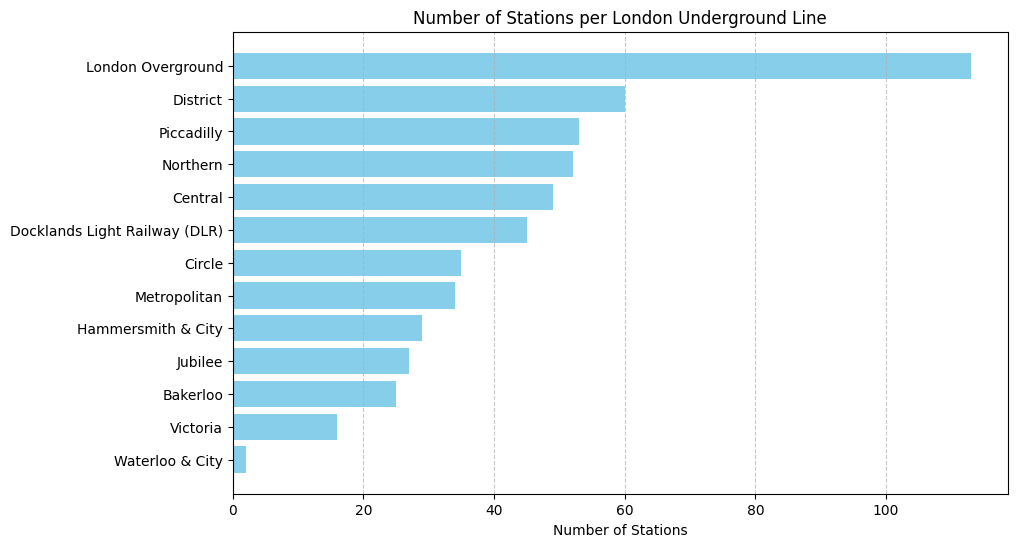

In [52]:
import matplotlib.pyplot as plt

# Data: London Underground lines and their respective number of stations
lines = [
    "Waterloo & City", "Victoria", "Jubilee", "Bakerloo", "Hammersmith & City",
    "Metropolitan", "Circle", "Northern", "Piccadilly", "Central", "District",
    "Docklands Light Railway (DLR)", "London Overground"
]
stations = [2, 16, 27, 25, 29, 34, 35, 52, 53, 49, 60, 45, 113]

# Combine lines and stations into a list of tuples and sort by number of stations
lines_stations = sorted(zip(stations, lines))

# Unzip the sorted tuples
stations_sorted, lines_sorted = zip(*lines_stations)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(lines_sorted, stations_sorted, color='skyblue')
plt.xlabel('Number of Stations')
plt.title('Number of Stations per London Underground Line')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


One of the most central subgraphs that also corresponds to a circle, is the Circle Line, which can be isolated in our Network as shown below.

Order of the Circle Line (number of stations): 35


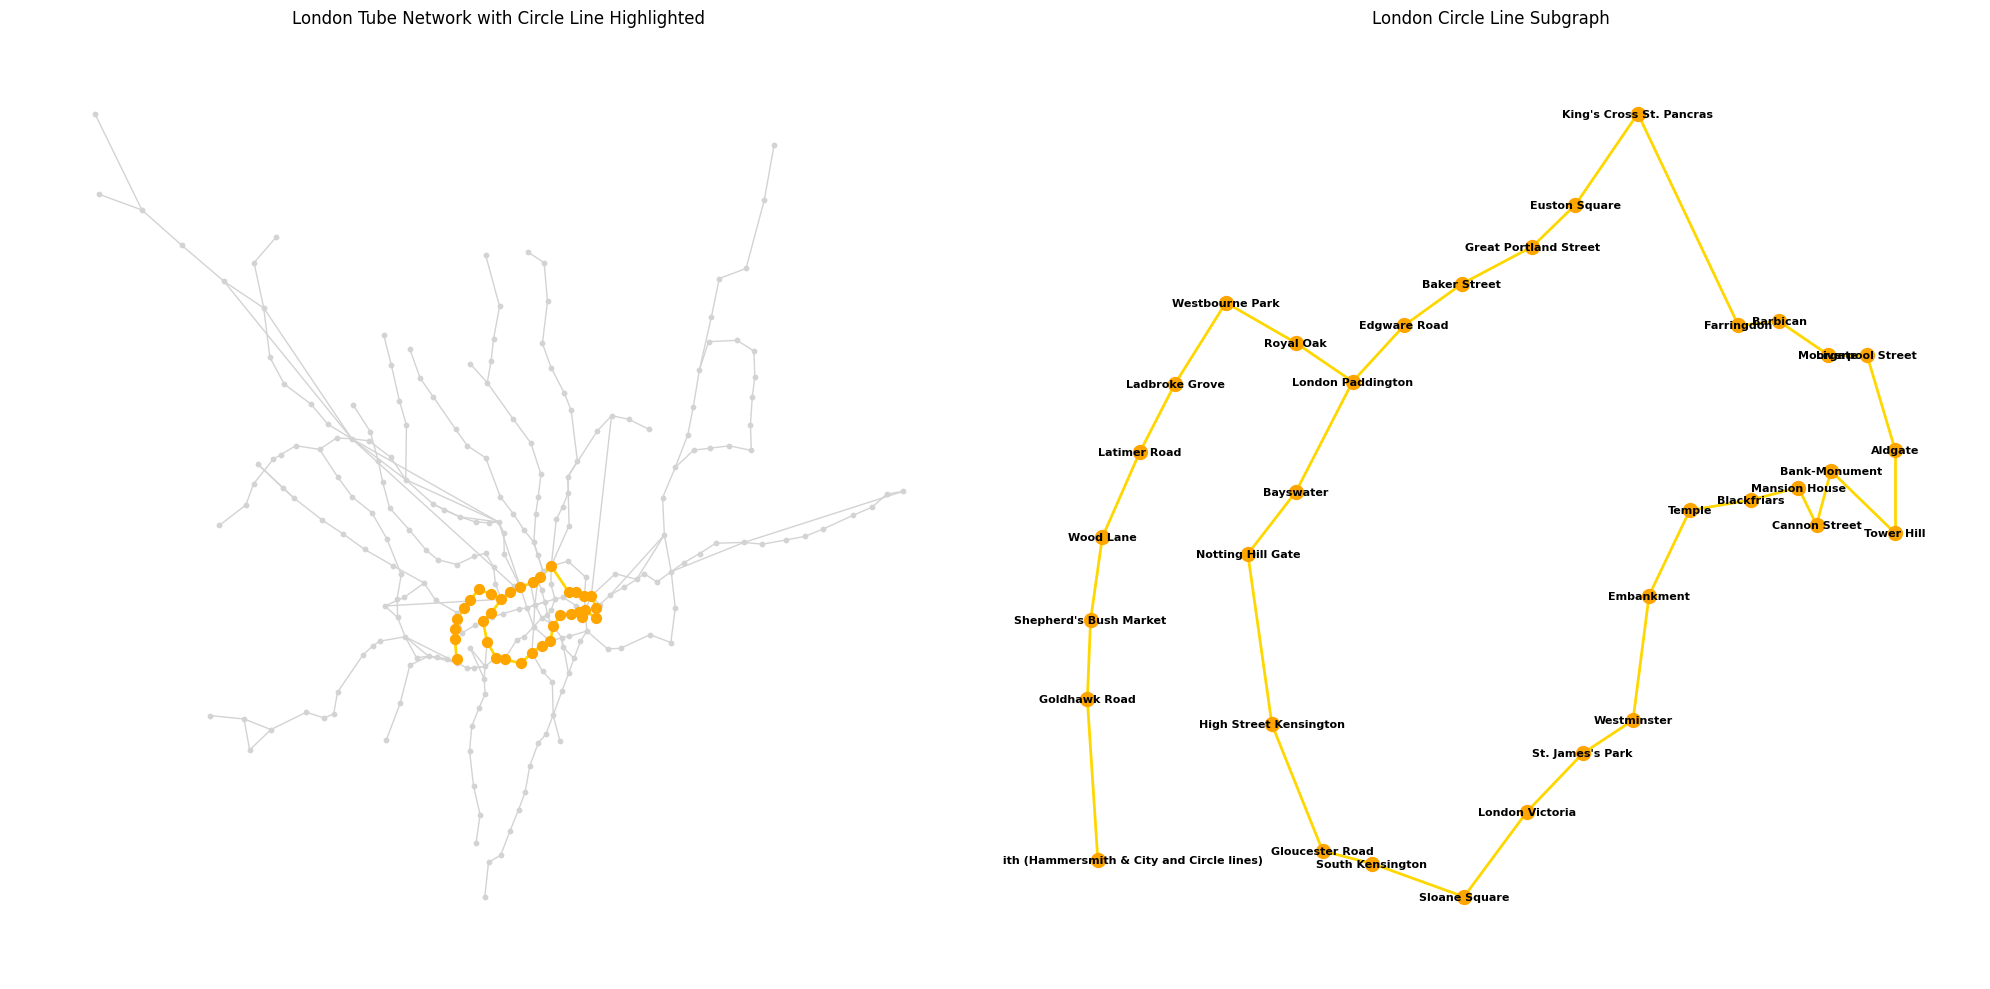

In [18]:
# Define the Circle Line stations
circle_line_stations = [
    "Hammersmith (Hammersmith & City and Circle lines)", "Goldhawk Road", 
    "Shepherd's Bush Market", "Wood Lane", "Latimer Road", "Ladbroke Grove", 
    "Westbourne Park", "Royal Oak", "London Paddington", "Edgware Road", 
    "Baker Street", "Great Portland Street", "Euston Square", 
    "King's Cross St. Pancras", "Farringdon", "Barbican", "Moorgate", 
    "Liverpool Street", "Aldgate", "Tower Hill", "Bank-Monument", 
    "Cannon Street", "Mansion House", "Blackfriars", "Temple", "Embankment", 
    "Westminster", "St. James's Park", "London Victoria", "Sloane Square", 
    "South Kensington", "Gloucester Road", "High Street Kensington", 
    "Notting Hill Gate", "Bayswater"
]

# Get station IDs and edges for the Circle Line
circle_line_station_ids = [node for node, name in labels.items() if name in circle_line_stations]
circle_line_edges = [(u, v) for u, v in G.edges() if u in circle_line_station_ids and v in circle_line_station_ids]
circle_line_edges = [edge for edge in circle_line_edges if edge not in [('282', '409'), ('282', '419')]]  # Remove incorrect edges
circle_line_nodes = set(circle_line_station_ids)

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the entire network with the Circle Line highlighted
nx.draw(
    G, 
    pos=pos_geo, 
    with_labels=False, 
    node_size=10, 
    node_color='lightgray', 
    edge_color='lightgray', 
    ax=axes[0]
)
nx.draw_networkx_edges(
    G, 
    pos=pos_geo, 
    edgelist=circle_line_edges, 
    edge_color='gold', 
    width=2, 
    ax=axes[0]
)
nx.draw_networkx_nodes(
    G, 
    pos=pos_geo, 
    nodelist=circle_line_nodes, 
    node_color='orange', 
    node_size=50, 
    ax=axes[0]
)

axes[0].set_title("London Tube Network with Circle Line Highlighted")

# Extract the subgraph of the Circle Line
circle_line_subgraph = G.subgraph(circle_line_nodes)

# Plot the Circle Line subgraph
nx.draw(
    circle_line_subgraph, 
    pos=pos_geo, 
    with_labels=True, 
    labels={node: labels[node] for node in circle_line_nodes}, 
    edgelist=circle_line_edges, 
    node_size=100, 
    node_color='orange', 
    font_size=8, 
    font_weight='bold', 
    edge_color='gold', 
    width=2, 
    ax=axes[1]
)
axes[1].set_title("London Circle Line Subgraph")


# Calculate the order (number of nodes) and size (number of edges) of the Circle Line
circle_line_order = len(circle_line_nodes)
circle_line_size = len(circle_line_edges)

print(f"Order of the Circle Line (number of stations): {circle_line_order}")

# Adjust layout
plt.tight_layout()
plt.show()


#### Degree distribution

__without weights__

The average degree is calculated to be 2.42, which aligns with expectations. As most stations in the metro network are typically connected by a single line, with each station having two adjacent connections: one to the previous station and one to the next. Such a structure is common in metro systems, where the majority of stations are part of a linear sequence of stops

In [53]:
# Calculate the average degree of the graph
average_degree = sum(dict(G.degree()).values()) / len(G.nodes())

print(f"Average degree of the network: {average_degree:.2f}")

Average degree of the network: 2.42


In general, we observe that that stations have a degree of two, being a pass through station on one of the lines. Then, there is a few nodes having degree 1 corresponding to end stops of lines and other stations with degree 3+ connecting two or more lines.

The top 5 nodes with the highest degrees in the network are Harrow-on-the-Hill, Baker Street, Bank-Monument, King's Cross St. Pancras, and Earl's court. Harrow-on-the-Hill stands out with the highest degree of 8, indicating it has the most connections in the network. The other two stations—Baker Street and King's Cross St. Pancras have a degree of 7, showing they are all well-connected with a similar number of edges. Following the other two reamingn stations Bank-monument and Earl's Court have a degree of 6, in general, these stations are central hubs in the network, with varying but significant levels of connectivity. 
These stations are all above the average degree of the network, which is 2.42. Their higher degrees suggest they are significantly more connected than the average station, reflecting their importance in facilitating movement and providing multiple transport links.
Some initial assumptions about their locations and roles in London transportation help provide context, a more detailed analysis would involve evaluating commuter traffic, station facilities, and transport links to further understand their importance within the network.

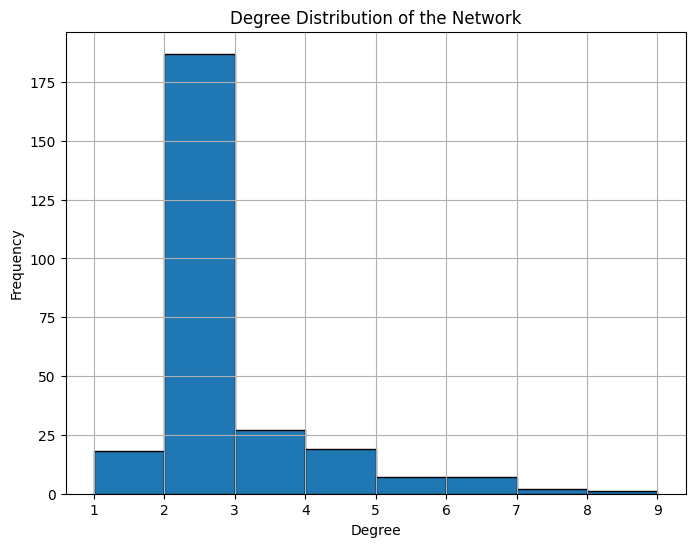


Top 5 nodes with the highest degrees:
Node: 371, Label: Harrow-on-the-Hill, Degree: 8
Node: 280, Label: Baker Street, Degree: 7
Node: 400, Label: King's Cross St. Pancras, Degree: 7
Node: 282, Label: Bank-Monument, Degree: 6
Node: 333, Label: Earl's Court, Degree: 6


In [54]:
# Degree of each node in the graph
degrees = dict(G.degree())  # {node: degree}

# Degree distribution (histogram)
degree_sequence = [degree for node, degree in degrees.items()]

# Plot the degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 2), edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find the top 5 nodes with the highest degrees
sorted_nodes_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 nodes with their degrees and labels
print("\nTop 5 nodes with the highest degrees:")
for node, degree in sorted_nodes_by_degree:
    label = G.nodes[node].get('label', 'No Label')
    print(f"Node: {node}, Label: {label}, Degree: {degree}")

__with weights__

The network's degree distribution reveals an average weighted degree of 1.77, indicating that, on average, each station has a relatively modest number of strong connections when considering the inverse of the distance as the weight. The arcs weighted by their inverse distance can in this case be interpreted as the geographical closeness of the station to other stations in the network, as the inverse of a small distance yields a large weight. The a large sum of these weights thus shows that a stations has either a few stations that are very close to it or many stations connected to it but that might be a bit further away. 

Notably, the top 5 stations with the highest weighted degrees, which are Bank-Monument (7.79), Leicester Square (7.18), Embankment (6.36), Charing Cross (5.92), and Waterloo (5.77), are all located in central and highly trafficked areas of the metro system. These stations exhibit significantly higher connectivity strength, suggesting they serve as major hubs where multiple metro lines converge. Their elevated weighted degrees reflect their crucial roles in the network, as they facilitate efficient transfers and high passenger flow. In the metro system is expected that the central stations are designed to handle high volumes of passengers and connections across various lines.

Average weighted degree: 1.77
Top 5 stations with highest weighted degrees:
Station: Bank-Monument (ID: 282), Weighted Degree: 7.79
Station: Leicester Square (ID: 406), Weighted Degree: 7.18
Station: Embankment (ID: 344), Weighted Degree: 6.36
Station: Charing Cross (ID: 314), Weighted Degree: 5.92
Station: Waterloo (ID: 515), Weighted Degree: 5.77


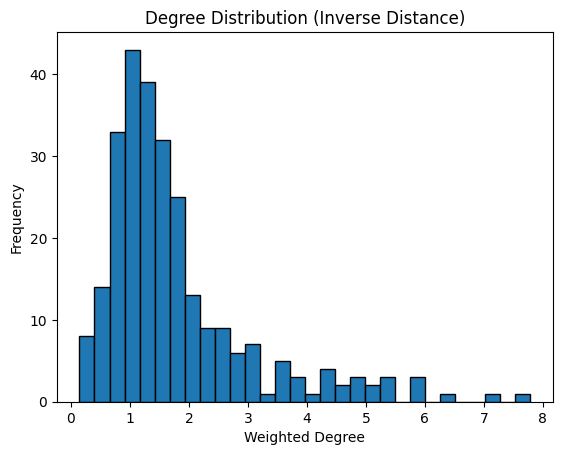

In [55]:
# Step 1: Calculate the weighted degree for each node (using inverse of the distance as weight)
def weighted_degree(graph, labels):
    weighted_degrees = {}
    for node in graph.nodes:
        weighted_degree = 0
        for neighbor in graph.neighbors(node):
            # Get the distance (weight) of the edge (inverse of distance as weight)
            weight = graph[node][neighbor].get('dist', 1)  # Default to 1 if no 'dist' attribute
            weighted_degree += 1 / weight  # Inverse of the distance as strength
        weighted_degrees[node] = weighted_degree
    return weighted_degrees

# Calculate the weighted degree of each station
weighted_degrees = weighted_degree(G, labels)

# Step 2: Calculate the average degree
average_degree = sum(weighted_degrees.values()) / len(weighted_degrees)
print(f"Average weighted degree: {average_degree:.2f}")

# Step 3: Identify the top 5 stations based on the weighted degree
top_5_stations = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

# Display the top 5 stations and their weighted degrees along with station names
print("Top 5 stations with highest weighted degrees:")
for node, degree in top_5_stations:
    station_name = labels.get(node, "Unknown Station")  # Get the station name using the label dictionary
    print(f"Station: {station_name} (ID: {node}), Weighted Degree: {degree:.2f}")

#Plotting the degree distribution (using the inverse distance)
# Get all weighted degrees for plotting
all_degrees = list(weighted_degrees.values())

# Plot the degree distribution
plt.hist(all_degrees, bins=30, edgecolor='black')
plt.title("Degree Distribution (Inverse Distance)")
plt.xlabel("Weighted Degree")
plt.ylabel("Frequency")
plt.show()


#### Number of components of the network

As mentioned before, the network is undirected, therefore the number of components in the London Undergroung metro system network reveals that there is only one connected component, indicating that all stations are part of a single, cohesive network. This suggests that the metro system is designed to ensure complete connectivity, with no isolated or disconnected stations. This is ensuring that every station can be reached from any other station, either directly or via transfer.

The fact that there is a single connected component also reflects the network's design efficiency, and confirms that the network is a weakly connected graph, you can travel between any two vertices by following some set of edges. This means that commuters can travel seamlessly between any two points within the system without encountering unreachable stations.
This networks helps in the flexibility of route planning, including multiple tranfer points in more central lines to be able to reach any part of the city that has a metro line.

Additionally, it will enfasises the importance of central lines that can have more traffic, and can serve as critical nodes in maintaining overall network cohesion.

In [56]:
#Find the connected components
connected_components = list(nx.connected_components(G))

#Calculate the number of connected components
num_components = len(connected_components)

print(f"Number of connected components: {num_components}")

Number of connected components: 1


#### Diameter

__without weights__

The longest shortest path between any two stations in the London Underground network spans 35 vertices (stations). It will indicates, the furthest distance between any two stations, based on the shortest possible route, requires traveling through 35 stations across the city.

In [57]:
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print(f"The diameter of the connected graph is: {diameter}")
else:
    print("The graph is disconnected.")

# Find the pair of nodes that defines the diameter
if nx.is_connected(G):
    diameter_path = nx.diameter(G)
    longest_shortest_path = nx.periphery(G)
    # Get the two nodes that define the diameter
    diameter_nodes = longest_shortest_path[:2]
    print(f"The diameter lies between stations: {diameter_nodes[0]} and {diameter_nodes[1]}")

The diameter of the connected graph is: 35
The diameter lies between stations: 345 and 370


The following code provides both the sequence of station names along the shortest route and the total distance of travel between the two specified stations, making it useful for analyzing travel routes in the London Undergroung metro system network.

The code calculates the total distance (sum of the weights) of the shortest path using Dijkstra's algorithm, which reflects the total travel distance between the two stations. If no path exists between the nodes or if a node is not found in the graph, appropriate error messages are displayed.   

In [58]:

def find_shortest_path(graph, initial_vertex, final_vertex):

    # Find the shortest path
    path = nx.dijkstra_path(graph, source=initial_vertex, target=final_vertex, weight='dist')
    path_station_names = [graph.nodes[node].get('label', 'No Label') for node in path]
    path_length = len(path) - 1
    path_distance = nx.dijkstra_path_length(graph, source=initial_vertex, target=final_vertex, weight='dist')


    print("Shortest Path (Node IDs):", path)
    print("Shortest Path (Station Names):", path_station_names)
    print("Number of Stations in Path:", path_length)
    print("Total Distance (km):", path_distance)
 

find_shortest_path(G, '345', '370')


Shortest Path (Node IDs): ['345', '494', '329', '411', '302', '537', '480', '473', '408', '407', '489', '530', '273', '409', '419', '283', '349', '400', '347', '360', '280', '341', '441', '514', '412', '398', '451', '392', '532', '369', '488', '517', '429', '477', '395', '370']
Shortest Path (Station Names): ['Epping', 'Theydon Bois', 'Debden', 'Loughton', 'Buckhurst Hill', 'Woodford', 'South Woodford', 'Snaresbrook', 'Leytonstone', 'Leyton', 'Stratford', 'Whitechapel', 'Aldgate East', 'Liverpool Street', 'Moorgate', 'Barbican', 'Farringdon', "King's Cross St. Pancras", 'Euston Square', 'Great Portland Street', 'Baker Street', 'Edgware Road', 'London Paddington', 'Warwick Avenue', 'Maida Vale', 'Kilburn Park', "Queen's Park", 'Kensal Green', 'Willesden Junction', 'Harlesden', 'Stonebridge Park', 'Wembley Central', 'North Wembley', 'South Kenton', 'Kenton', 'Harrow & Wealdstone']
Number of Stations in Path: 35
Total Distance (km): 64.2756406417444


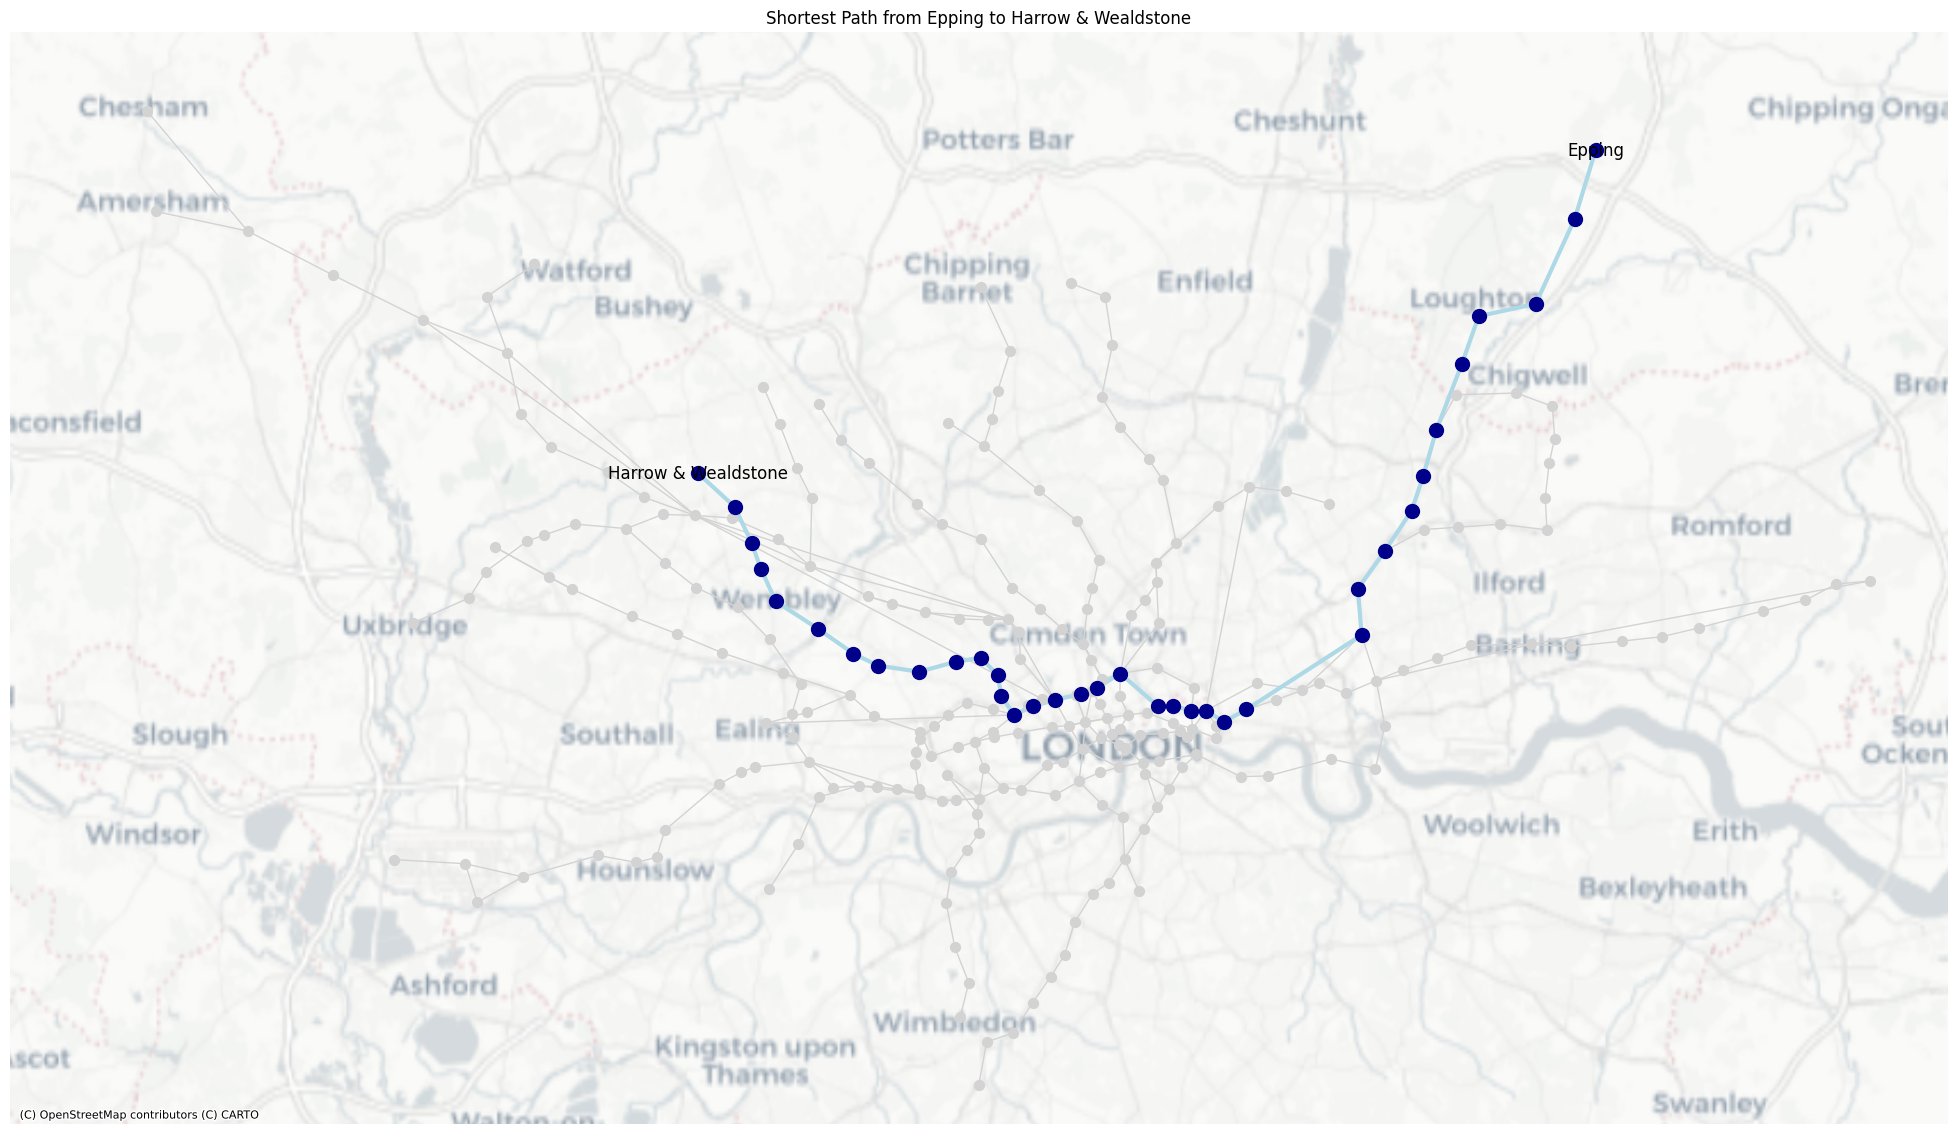

In [59]:
plot_shortest_path(G, '345', '370')

__with weights__

we can also calculate the weighted diameter which corresponds to the longest shortest path distance wise.

In [60]:
# Calculate the shortest path lengths using inverse distance as weights
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight=lambda u, v, d: 1 / d['dist'] if 'dist' in d else float('inf')))

# Find the diameter (maximum shortest path length)
weighted_diameter = max(max(lengths.values()) for lengths in shortest_path_lengths.values())

print(f"The diameter of the graph with weights (inverse distance) is: {weighted_diameter}")

# Find the pair of stations corresponding to the weighted diameter
for source, lengths in shortest_path_lengths.items():
    for target, length in lengths.items():
        if length == weighted_diameter:
            print(f"The two stations corresponding to the weighted diameter are: {source} and {target}")
            break

The diameter of the graph with weights (inverse distance) is: 23.68140839665368
The two stations corresponding to the weighted diameter are: 421 and 366


In [61]:
find_shortest_path(G, '421', '366')

Shortest Path (Node IDs): ['421', '479', '324', '496', '495', '281', '321', '319', '320', '487', '509', '446', '510', '362', '294', '280', '341', '441', '461', '527', '402', '405', '536', '471', '357', '366']
Shortest Path (Station Names): ['Morden', 'South Wimbledon', 'Colliers Wood', 'Tooting Broadway', 'Tooting Bec', 'Balham', 'Clapham South', 'Clapham Common', 'Clapham North', 'Stockwell', 'Vauxhall', 'Pimlico', 'London Victoria', 'Green Park', 'Bond Street', 'Baker Street', 'Edgware Road', 'London Paddington', 'Royal Oak', 'Westbourne Park', 'Ladbroke Grove', 'Latimer Road', 'Wood Lane', "Shepherd's Bush Market", 'Goldhawk Road', 'Hammersmith (Hammersmith & City and Circle lines)']
Number of Stations in Path: 25
Total Distance (km): 29.120318862949997


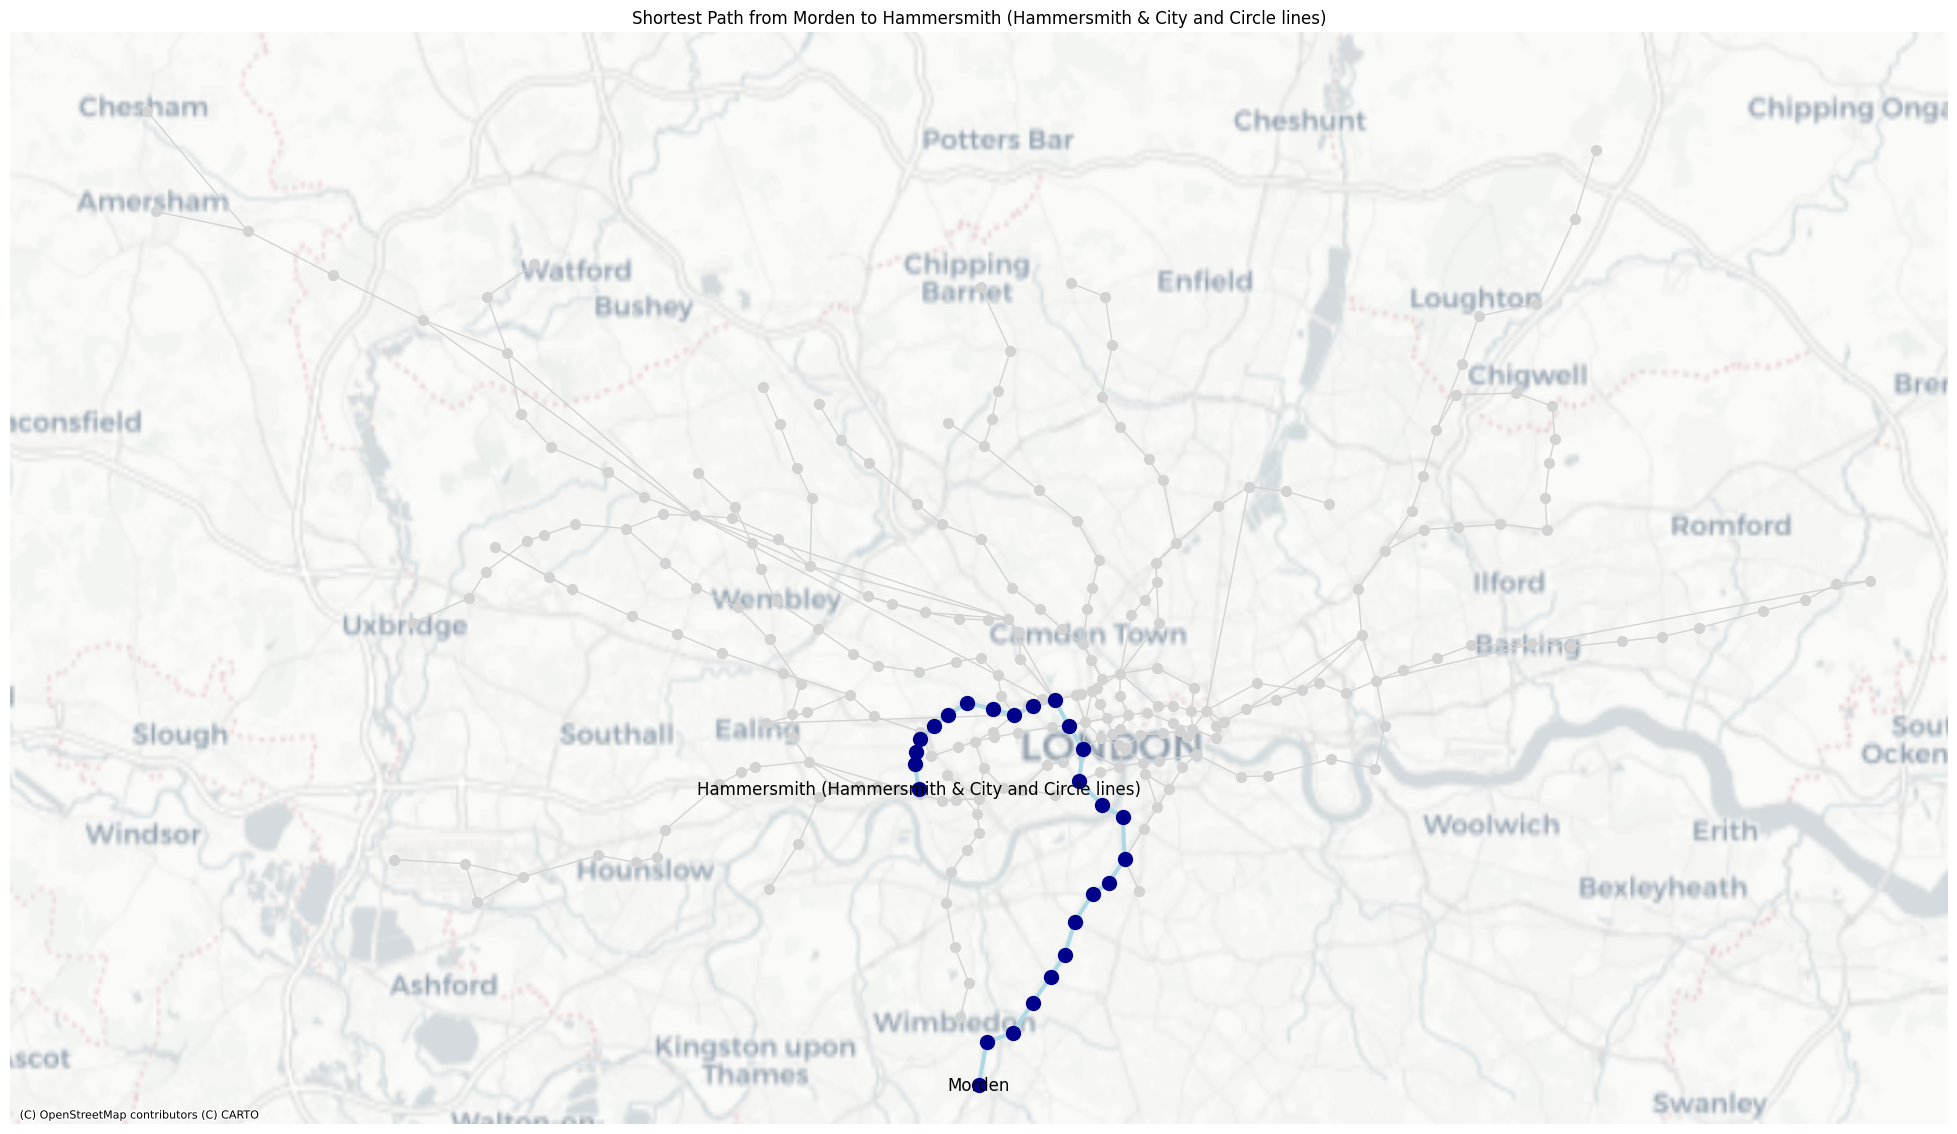

In [62]:
plot_shortest_path(G, '421', '366')

#### Adjecency Matrix
Using the Adjecency Matrix, we can calculate the mean giving us an average 0.009 Arcs per nodes^2, showing that overall there is very low connectivity in the network.

In [63]:
import scipy.io

# Generate the adjacency matrix
adj_matrix = nx.adjacency_matrix(G)
adj_matrix_dense = adj_matrix.todense()

# Calculate the mean
mean_adj_matrix = np.mean(adj_matrix_dense)
print(f"Mean of the adjacency matrix: {mean_adj_matrix}")

Mean of the adjacency matrix: 0.009022053909556694


## Attribute Analysis

With the main characteristics of the Network analyzed, we additionally do a brief Exploratory Data Analysis into the Attributes of the Network. This knowlegde might be useful in later interpretations of properties of the Network.

### Edges

A histogram can be plotted to show the distribution of the distances and the mean distance (km) between stations. It has to be remembered as the distance is a linear approximation (e.g. euclidean distance) and the effective distances that are traveled between stations are slightly higher.

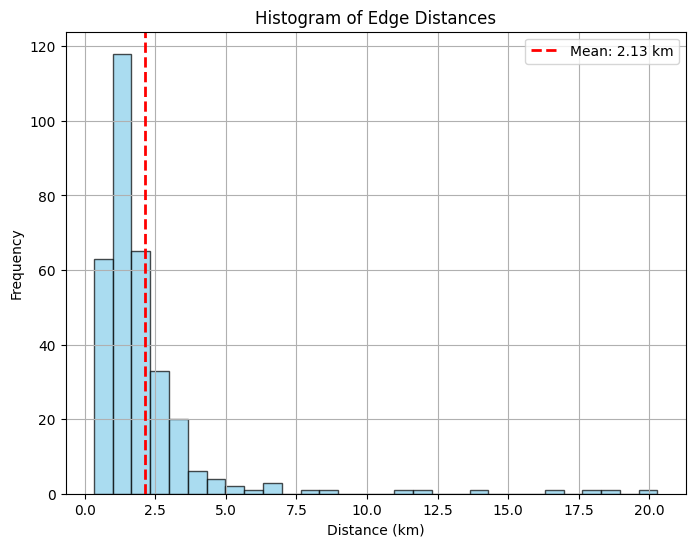

In [64]:
# Plot the histogram
distances = [data['dist'] for _, _, data in G.edges(data=True) if 'dist' in data]
mean_distance = np.mean(distances)

plt.figure(figsize=(8, 6))
plt.hist(distances, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(mean_distance, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f} km')
plt.title('Histogram of Edge Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### Nodes

The main attributes of the nodes correspond to the average entries and exits of the stations on weekdays and weekends. We can begin the analysis by plotting a colormapped network plot with the color corresponding to the entires/exits.

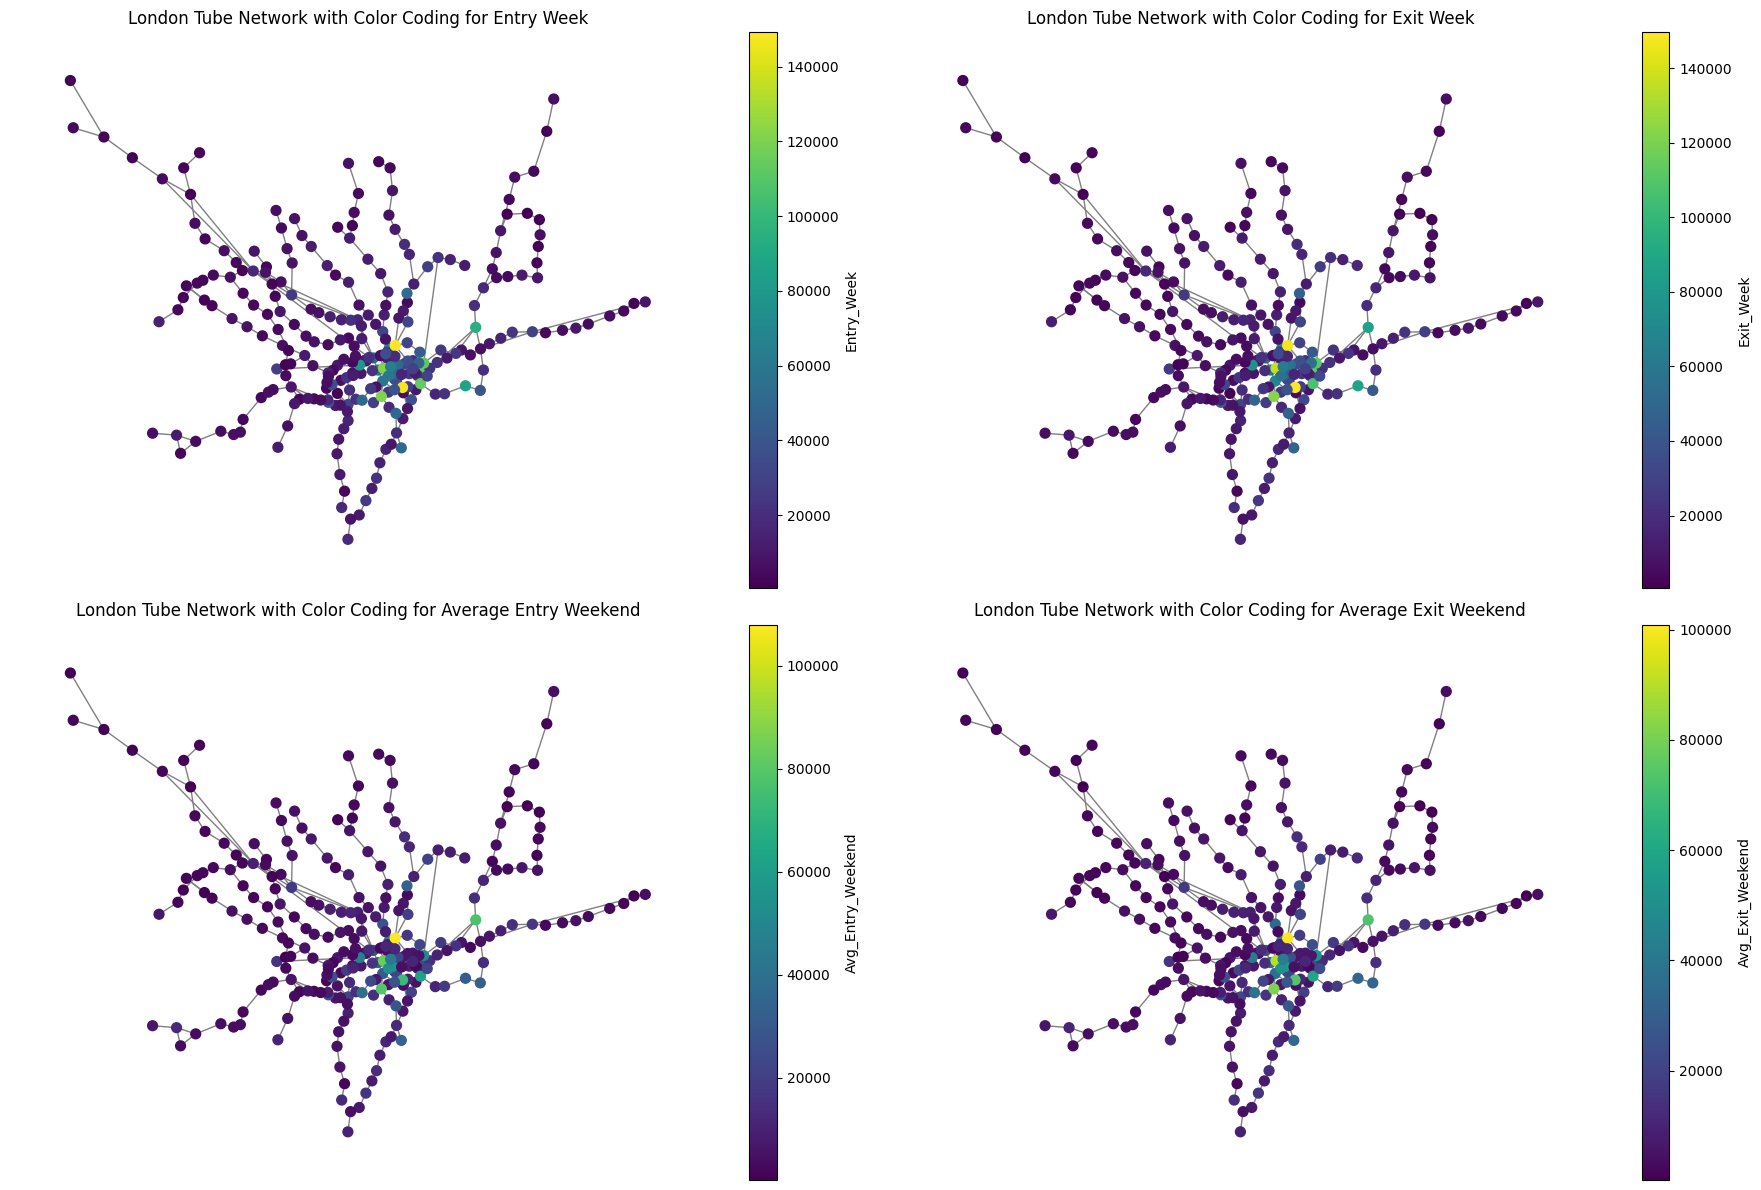

In [65]:
# Define the categories to visualize and their corresponding titles
categories = ['Entry_Week', 'Exit_Week', 'Avg_Entry_Weekend', 'Avg_Exit_Weekend']
titles = ['Entry Week', 'Exit Week', 'Average Entry Weekend', 'Average Exit Weekend']

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Iterate over the categories and plot each one
for i, (category, title) in enumerate(zip(categories, titles)):
    # Extract values for the current category
    values = [data[category] for _, data in G.nodes(data=True) if category in data]
    
    # Normalize the values for the colormap
    norm = plt.Normalize(min(values), max(values))
    cmap = plt.cm.viridis
    
    # Create a color map for the nodes
    node_colors = [cmap(norm(data[category])) if category in data else (0.5, 0.5, 0.5, 1) for _, data in G.nodes(data=True)]
    
    # Plot the network on the corresponding subplot
    ax = axes[i // 2, i % 2]
    nx.draw(
        G, 
        pos=pos_geo, 
        with_labels=False, 
        node_size=50, 
        node_color=node_colors, 
        edge_color='gray',
        ax=ax
    )
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(category)
    
    # Set the title for the subplot
    ax.set_title(f"London Tube Network with Color Coding for {title}")

# Adjust layout
plt.tight_layout()
plt.show()

Furthermore, histograms for the exits and entires on weekdays and weekends of the stations can be plotted, showing a similar distribution to that of the degrees.

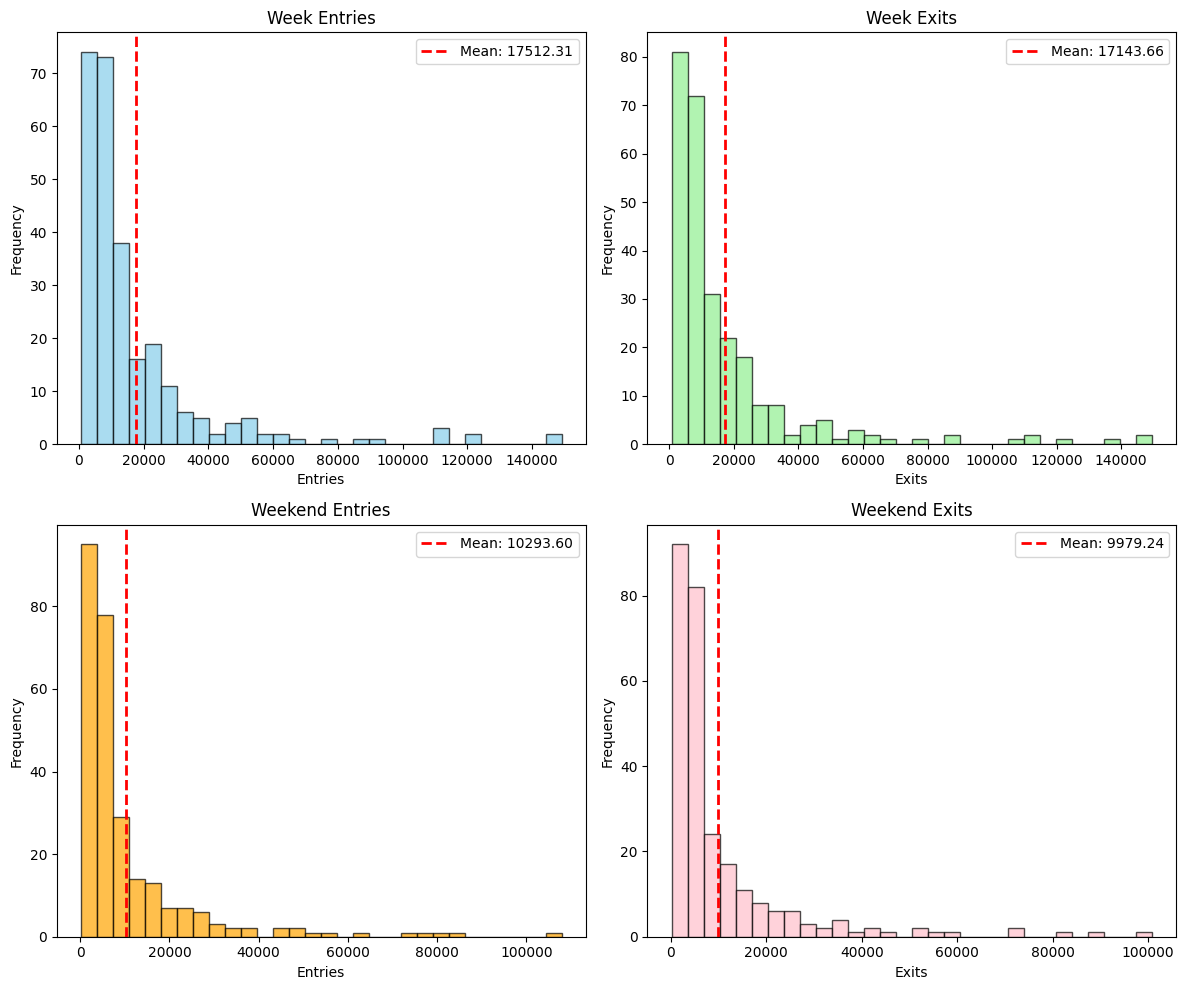

In [66]:
# Extract data for histograms directly from the graph
entry_week = [data['Entry_Week'] for _, data in G.nodes(data=True) if 'Entry_Week' in data]
exit_week = [data['Exit_Week'] for _, data in G.nodes(data=True) if 'Exit_Week' in data]
avg_entry_weekend = [data['Avg_Entry_Weekend'] for _, data in G.nodes(data=True) if 'Avg_Entry_Weekend' in data]
avg_exit_weekend = [data['Avg_Exit_Weekend'] for _, data in G.nodes(data=True) if 'Avg_Exit_Weekend' in data]

# Calculate means
mean_entry_week = np.mean(entry_week)
mean_exit_week = np.mean(exit_week)
mean_avg_entry_weekend = np.mean(avg_entry_weekend)
mean_avg_exit_weekend = np.mean(avg_exit_weekend)

# Create a 4x4 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms with mean lines
axes[0, 0].hist(entry_week, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(mean_entry_week, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_entry_week:.2f}')
axes[0, 0].set_title('Week Entries')
axes[0, 0].set_xlabel('Entries')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(exit_week, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(mean_exit_week, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_exit_week:.2f}')
axes[0, 1].set_title('Week Exits')
axes[0, 1].set_xlabel('Exits')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[1, 0].hist(avg_entry_weekend, bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(mean_avg_entry_weekend, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_avg_entry_weekend:.2f}')
axes[1, 0].set_title('Weekend Entries')
axes[1, 0].set_xlabel('Entries')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(avg_exit_weekend, bins=30, color='pink', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(mean_avg_exit_weekend, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_avg_exit_weekend:.2f}')
axes[1, 1].set_title('Weekend Exits')
axes[1, 1].set_xlabel('Exits')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

We can also plot barplots of the top exitede/entered stations, showing that those do not correspond well to the stations with the highest degrees in the network (only Kings Cross Coincides). We thus conclude that the Stations with high degrees are more used to change between lines than as start or end of journeys. The two most used stations on weekdays are the two major train stations Kings Cross and Waterloo, which probably corresponds to people coming to the city for work, while Waterlpoos significance reduces on weekends.  

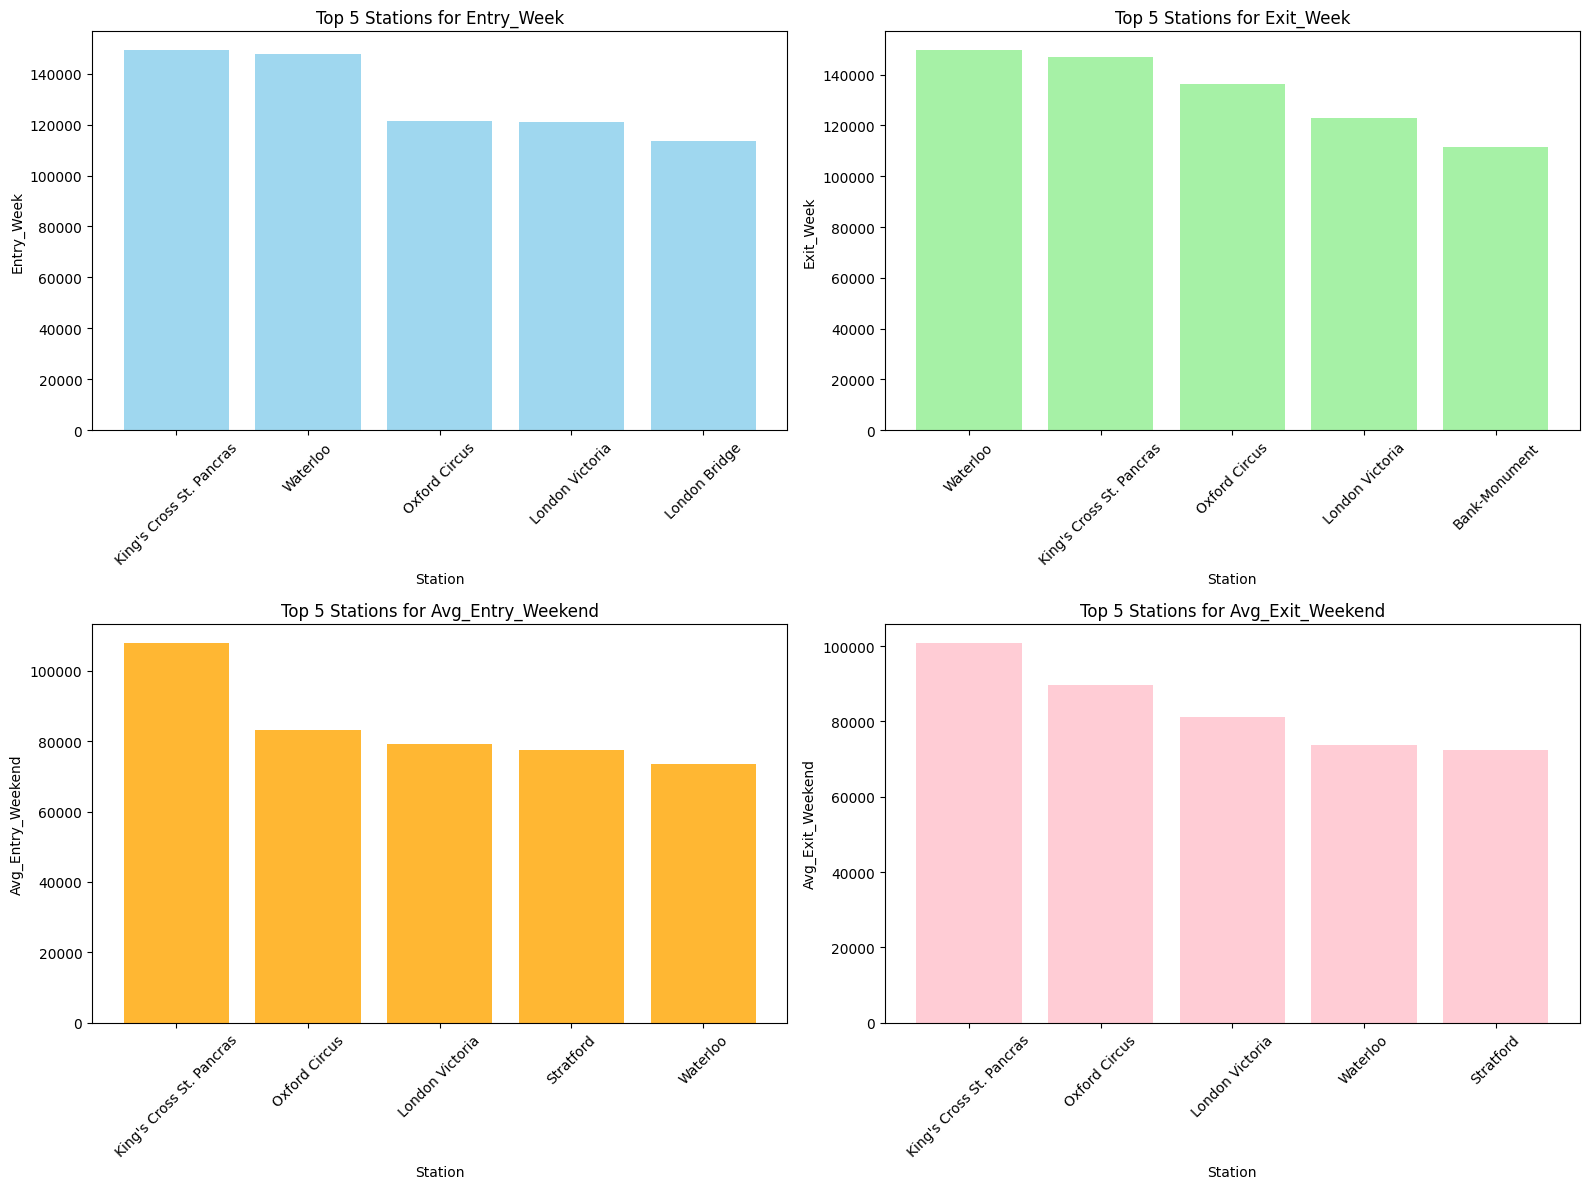

In [67]:
# Define the categories to analyze and their corresponding colors
categories = ['Entry_Week', 'Exit_Week', 'Avg_Entry_Weekend', 'Avg_Exit_Weekend']
colors = ['skyblue', 'lightgreen', 'orange', 'pink']

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot bar diagrams for the top 5 most used stations in each category
for i, category in enumerate(categories):
    row, col = divmod(i, 2)
    top_stations = usage_data.nlargest(5, category)[['Station', category]]
    
    # Create a bar plot in the corresponding subplot
    axes[row, col].bar(top_stations['Station'], top_stations[category], color=colors[i], alpha=0.8)
    axes[row, col].set_title(f"Top 5 Stations for {category}")
    axes[row, col].set_xlabel("Station")
    axes[row, col].set_ylabel(category)
    axes[row, col].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

These top 5 Stations marked on the map however still appera to be very much in the city center, as could be expected.

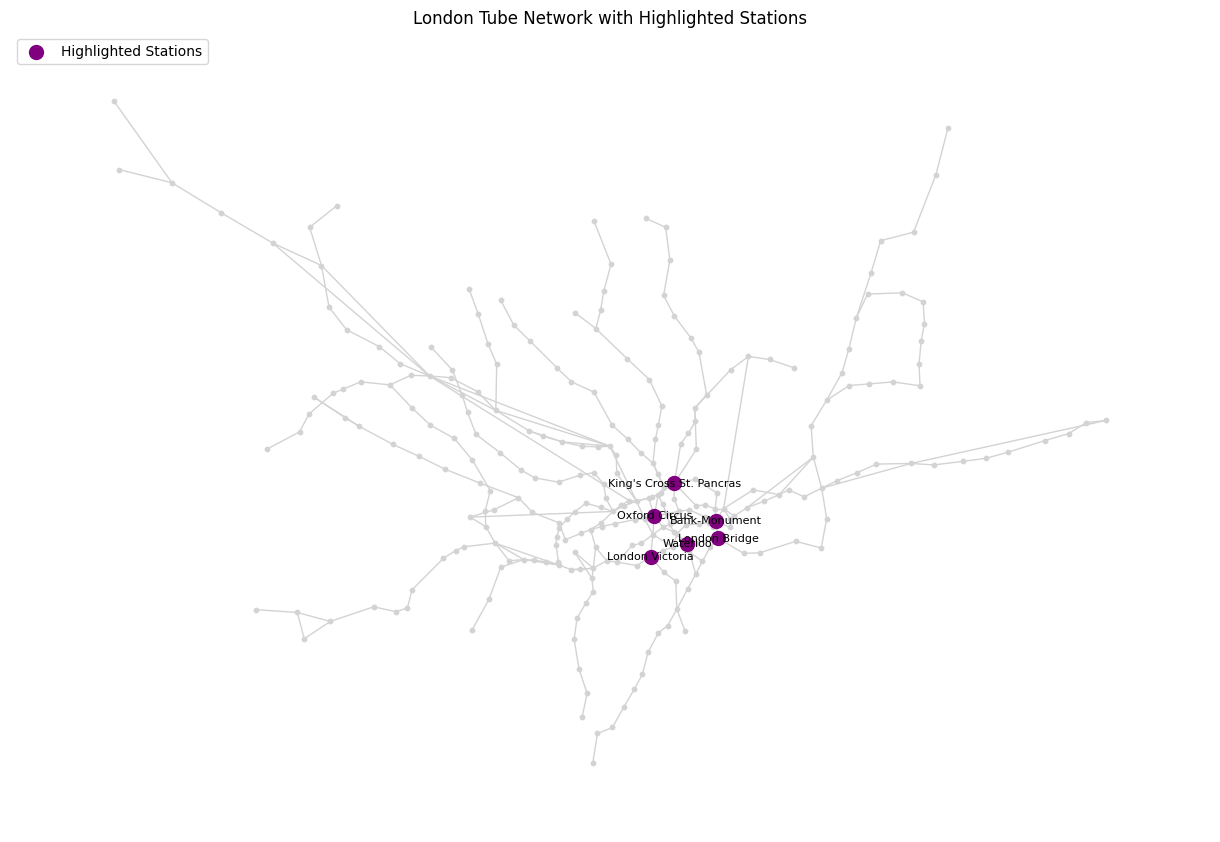

In [68]:
# Identify the top 5 most exited and most entered stations
top_5_exited = usage_data.nlargest(5, 'Exit_Week')[['Station', 'Exit_Week']]
top_5_entered = usage_data.nlargest(5, 'Entry_Week')[['Station', 'Entry_Week']]

# Combine the top 5 exited and entered stations into a single set
top_5_combined_stations = set(top_5_exited['Station']).union(set(top_5_entered['Station']))
top_5_combined_nodes = [node for node, label in labels.items() if label in top_5_combined_stations]

# Example usage
stations_to_highlight = ['Oxford Circus', 'Bank-Monument', 'London Victoria', 'London Bridge', "King's Cross St. Pancras", 'Waterloo']
plot_highlighted_stations(G, pos_geo, top_5_combined_nodes, labels)



## Advanced Network Visualization

With the properties of the Network defined and a general understanding of the Node and Edge attributes, we continue with advanced visualization tecniques to gain further understanding of the Networks.

#### Energy based Visualizations

Following graphs layouts are based on energy functions, where the algorithm simulates physical forces to determine node positions. The layout process aims to minimize a global energy function.

The main focus in the London Underground Network with the corresponding energy layouts is to reveal clusters, central hubs or important vertex in a clearer visually way. 

#### Davidson and Harel layout:

The Davidson and Harel layout will aim for a result with a minimal edge crossing. It is plotted the layouts with the stations names and node number for easier visualization.

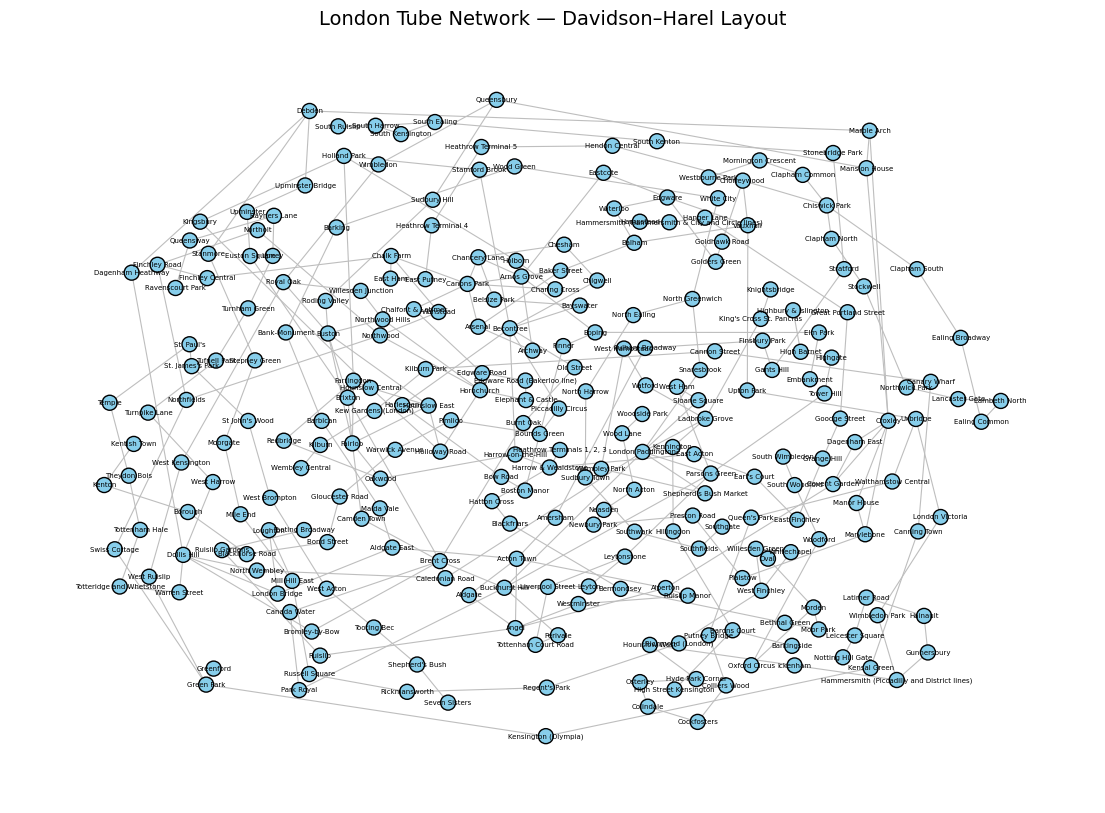

In [69]:
import igraph as ig
#Convert NetworkX graph to igraph
edges_i = list(G.edges())
ig_graph = ig.Graph.TupleList(edges_i, directed=False)

#Add station names as vertex labels
if 'label' in list(G.nodes(data=True))[0][1]:
    station_labels = [data['label'] for _, data in G.nodes(data=True)]
else:
    # Fallback to node IDs
    station_labels = [str(n) for n in G.nodes()]

ig_graph.vs["name"] = station_labels

#Compute Davidson–Harel layout
layout_dh = ig_graph.layout("dh")

#Plot the graph
fig, ax = plt.subplots(figsize=(14, 10))
ig.plot(
    ig_graph,
    layout=layout_dh,
    target=ax,
    vertex_label=ig_graph.vs["name"],
    vertex_size=15,
    vertex_color="skyblue",
    edge_color="gray",
    edge_width=0.8,
    vertex_label_size=5,
)
plt.title("London Tube Network — Davidson–Harel Layout", fontsize=14)
plt.axis('off')
plt.show()

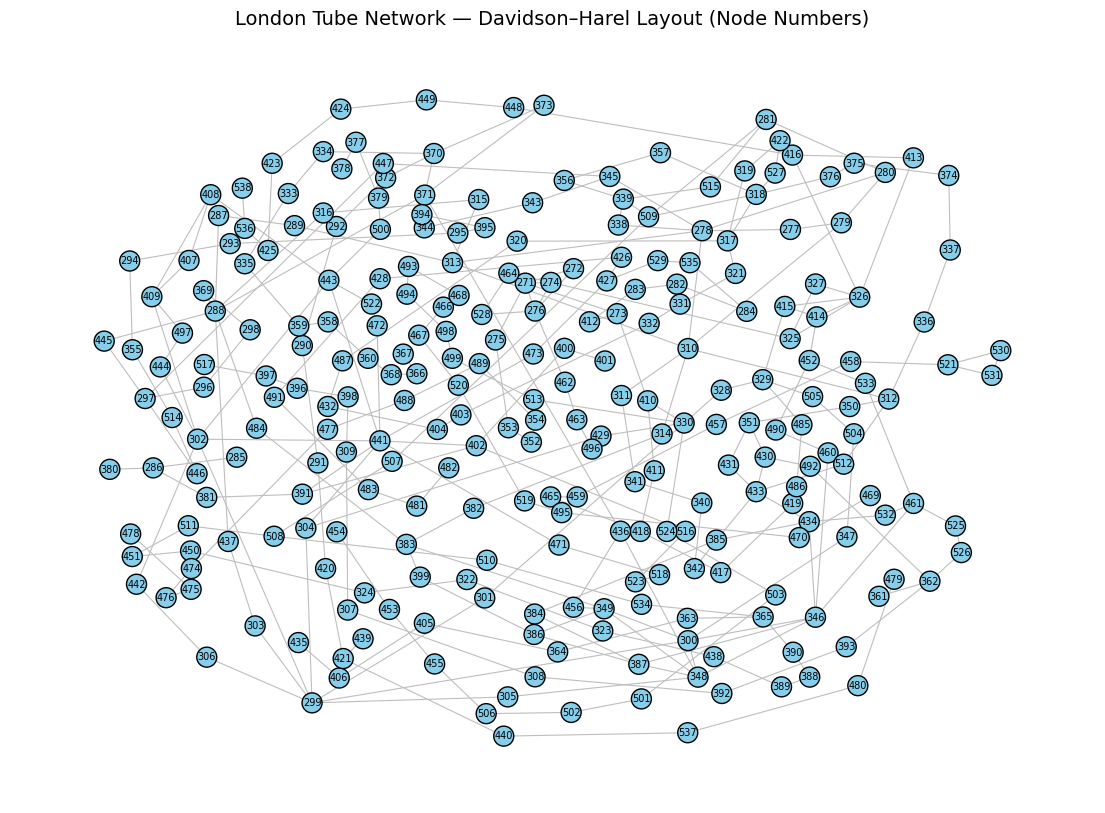

In [74]:

# Use original NetworkX node numbers as labels
# These are the unique node identifiers in G
node_ids = list(G.nodes())
ig_graph.vs["name"] = [str(n) for n in node_ids]  # Cast to str for labeling

# Compute Davidson–Harel layout
layout_dh = ig_graph.layout("dh")

# Plot the graph with node number labels
fig, ax = plt.subplots(figsize=(14, 10))
ig.plot(
    ig_graph,
    layout=layout_dh,
    target=ax,
    vertex_label=ig_graph.vs["name"],
    vertex_size=20,
    vertex_color="skyblue",
    edge_color="gray",
    edge_width=0.8,
    vertex_label_size=7,
)
plt.title("London Tube Network — Davidson–Harel Layout (Node Numbers)", fontsize=14)
plt.axis('off')
plt.show()


The Davidson and Harel layout applied to the London Underground metro system produces a circular, evenly distributed visualization where no particular emphasis is placed on important stations or clusters. All nodes (stations) are positioned based on force-directed principles, without automatically highlighting central hubs or high-connectivity areas. As a result, key stations with higher degrees are not visually distinguished. To address this, we will manually highlight the stations with the highest degrees to better illustrate their significance within the network.

Let's called again the top 5 nodes with the highest unweighted degrees.

In [96]:
# Print the top 5 nodes with their degrees and labels
print("\nTop 5 nodes with the highest degrees:")
for node, degree in sorted_nodes_by_degree:
    label = G.nodes[node].get('label', 'No Label')
    print(f"Node: {node}, Label: {label}, Degree: {degree}")


Top 5 nodes with the highest degrees:
Node: 371, Label: Harrow-on-the-Hill, Degree: 8
Node: 280, Label: Baker Street, Degree: 7
Node: 400, Label: King's Cross St. Pancras, Degree: 7
Node: 282, Label: Bank-Monument, Degree: 6
Node: 333, Label: Earl's Court, Degree: 6


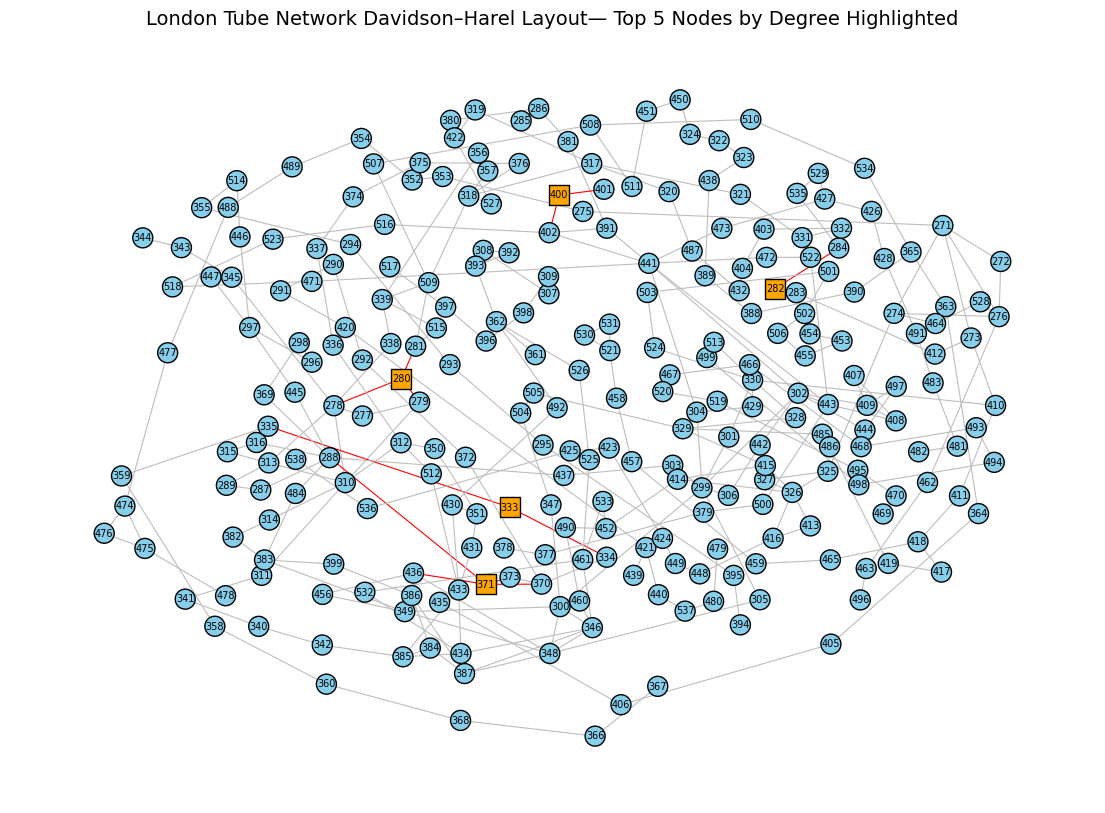

In [ ]:
highlight_labels =  ['371','280','400','282','333']
vertex_colors = ['orange' if name in highlight_labels else 'skyblue' for name in ig_graph.vs["name"]]
vertex_shapes = ['square' if name in highlight_labels else 'circle' for name in ig_graph.vs["name"]]

# Highlight edges connected to top nodes
edge_colors = []
for edge in ig_graph.es:
    src = ig_graph.vs[edge.source]["name"]
    tgt = ig_graph.vs[edge.target]["name"]
    if src in highlight_labels or tgt in highlight_labels:
        edge_colors.append('red')
    else:
        edge_colors.append('gray')

#  Layout and plot 
layout_dh = ig_graph.layout("dh")

fig, ax = plt.subplots(figsize=(14, 10))
ig.plot(
    ig_graph,
    layout=layout_dh,
    target=ax,
    vertex_label=ig_graph.vs["name"],
    vertex_size=20,
    vertex_color=vertex_colors,
    vertex_shape=vertex_shapes,
    edge_color=edge_colors,
    edge_width=0.8,
    vertex_label_size=7,
)
plt.title("London Tube Network Davidson–Harel Layout— Top 5 Nodes by Degree Highlighted", fontsize=14)
plt.axis('off')
plt.show()

 #####  Kamada and Kawai layout:

The Kamada and Kawait layout (another type of energy-based graph visualization method) aims to position nodes so their shortest path distances are preserved as accurately as possible, related nodes are placed closer together and overall structure is more readable.

The Kamada and Kawai layout produces a visualization that closely resembles the actual geographic structure of the London Underground, though not an exact match. By approximating ideal distances between all pairs of stations based on their shortest path lengths, the layout naturally forms a tree-like structure, with several "arms" of the network radiating outward from the central hub stations. This helps to visually emphasize how the main lines converge in central London, reflecting the real-world connectivity and flow of the metro system. 

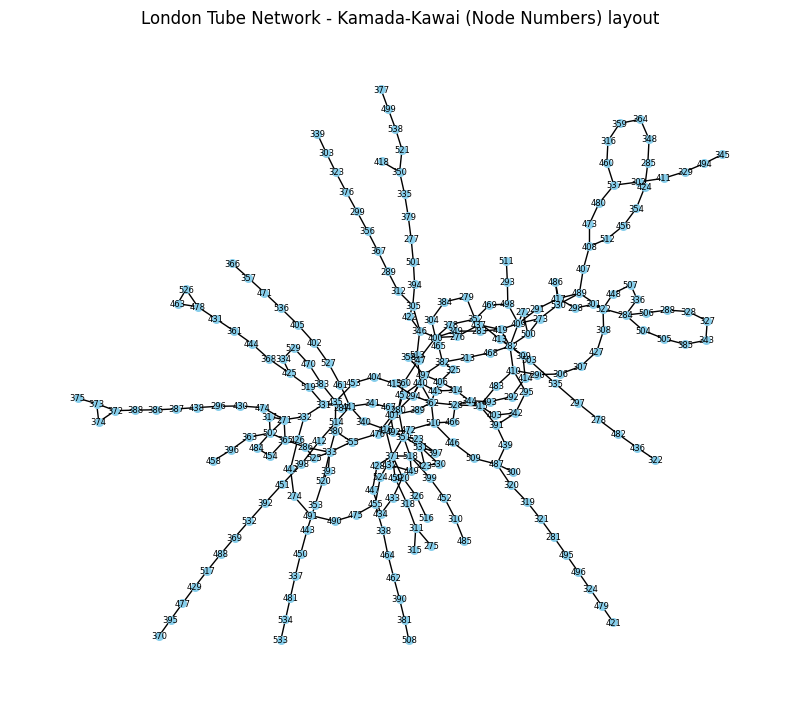

In [71]:
# Define layouts
layouts = {
    "London Tube Network - Kamada-Kawai (Node Numbers)": nx.kamada_kawai_layout,
}

plt.figure(figsize=(24, 14))
for i, (name, layout_func) in enumerate(layouts.items(), 1):
    pos = layout_func(G)
    plt.subplot(2, 3, i)
    nx.draw(G, pos, with_labels=True, node_size=30, node_color='skyblue', font_size=6)
    plt.title(f"{name} layout")

plt.tight_layout()
plt.show()

The following code highlights stations with more than three connections (a degree greater than 3) in the unweighted graph of the London Underground network. As seen in the resulting layout, these high-degree stations are predominantly located near the center of the network. This distribution aligns with the real-world structure of London, where central stations act as major interchange hubs, facilitating connectivity between multiple lines. These central nodes play a crucial role in ensuring efficient passenger flow across the broader metro system.

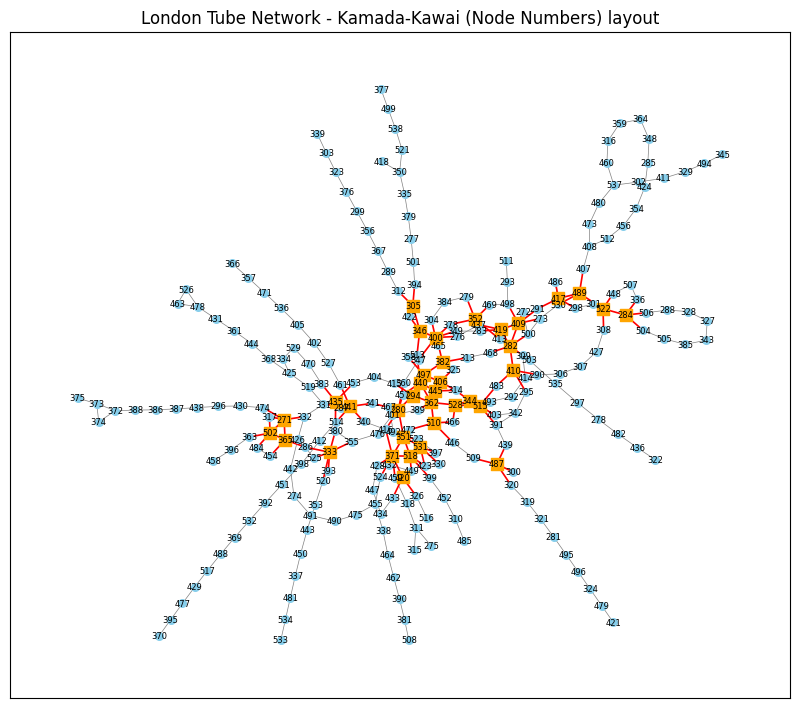

In [ ]:
# Define layouts
layouts = {
    "London Tube Network - Kamada-Kawai (Node Numbers)": nx.kamada_kawai_layout,
}

# Identify nodes with degree > 3
high_degree_nodes = [n for n in G.nodes if G.degree(n) > 3]
low_degree_nodes = [n for n in G.nodes if G.degree(n) <= 3]

# Identify edges that connect to high-degree nodes
high_degree_edges = [e for e in G.edges if e[0] in high_degree_nodes or e[1] in high_degree_nodes]
low_degree_edges = list(set(G.edges) - set(high_degree_edges))

plt.figure(figsize=(24, 14))
for i, (name, layout_func) in enumerate(layouts.items(), 1):
    pos = layout_func(G)
    plt.subplot(2, 3, i)

    # Draw low-degree nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=low_degree_nodes,
                           node_color='skyblue',
                           node_shape='o',
                           node_size=30)

    # Draw high-degree nodes with a different shape and color
    nx.draw_networkx_nodes(G, pos,
                           nodelist=high_degree_nodes,
                           node_color='orange',
                           node_shape='s',  # square
                           node_size=80)

    # Draw edges not connected to high-degree nodes
    nx.draw_networkx_edges(G, pos,
                           edgelist=low_degree_edges,
                           edge_color='gray',
                           width=0.5)

    # Draw edges connected to high-degree nodes
    nx.draw_networkx_edges(G, pos,
                           edgelist=high_degree_edges,
                           edge_color='red',
                           width=1.2)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=6)

    plt.title(f"{name} layout")

plt.tight_layout()
plt.show()


#### Fruchterman-Reingold

The Fruchterman-Reingol layout, treats nodes like charged particles that repel each other, while edges act like springs that pull connected nodes together, resulting in a layout where related nodes are placed closer together and the overall structure is more visually intuitive.

When applied to the London Underground network, the Fruchterman-Reingold layout reveals a general structure where some "arms" of the network, representing individual metro lines, extend outward with stations connected in a linear fashion. However, the central area appears denser and more tangled, lacking clear clustering or emphasis on specific stations. While the layout does not explicitly highlight important hubs, the visual density at the center suggests the presence of key interchange stations where multiple lines converge. This reflects the real-world role of central London stations as critical connection points within the network.

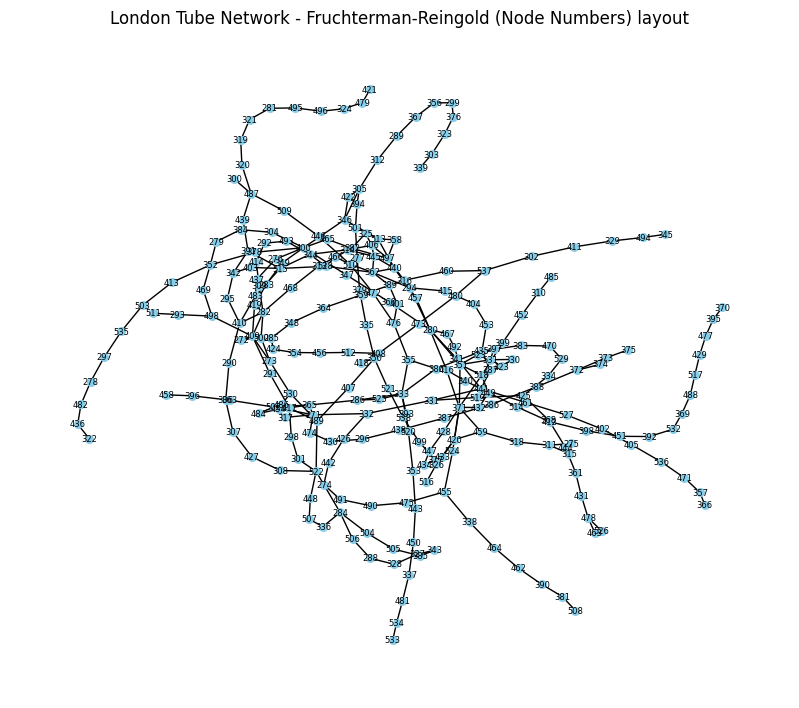

In [106]:
# Define layouts
layouts = {
    "London Tube Network - Fruchterman-Reingold (Node Numbers)":nx.spring_layout,
}

plt.figure(figsize=(24, 14))
for i, (name, layout_func) in enumerate(layouts.items(), 1):
    pos = layout_func(G, seed = 1)
    plt.subplot(2, 3, i)
    nx.draw(G, pos, with_labels=True, node_size=30, node_color='skyblue', font_size=6)
    plt.title(f"{name} layout")

plt.tight_layout()
plt.show()

Additionally, the following code will run and highlight the Frecheman algorithm with a higlight in the nodes that have a weighted degree greateer than 4 , calculate as the inverse for the distance, as being a metro system, we confirm some nodes in the part of the center of the grapg are going to be higlighted, and going to investigate the station 471 as is a part of an arm , why it is being calculated further on. 

The following code applies the Fruchterman-Reingold force-directed algorithm to visualize the London Underground network. It highlights stations (nodes) whose weighted degree—calculated as the sum of the inverse distances to neighboring stations—exceeds a value of 4. Since this network represents a metro system, stations located in central London, where multiple lines intersect and distances between stations are shorter, are more likely to meet this threshold. As expected, several central nodes are visually emphasized in the layout. Notably, station 471, which appears along one of the network's outer branches, is also highlighted. This prompts a closer investigation into its structure and connections to understand why it stands out in terms of weighted connectivity.

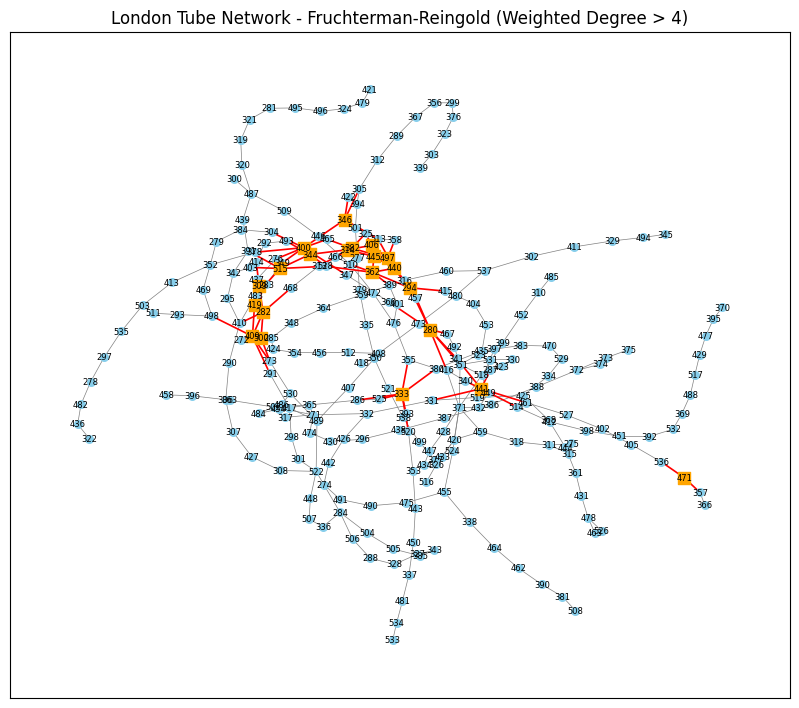

In [105]:
# Step 1: Calculate the weighted degree for each node using inverse of the distance
def weighted_degree(graph):
    weighted_degrees = {}
    for node in graph.nodes:
        w_degree = 0
        for neighbor in graph.neighbors(node):
            weight = graph[node][neighbor].get('dist', 1)  # Default to 1 if no 'dist'
            if weight > 0:
                w_degree += 1 / weight
        weighted_degrees[node] = w_degree
    return weighted_degrees

# Calculate weighted degrees
weighted_degrees = weighted_degree(G)

# Threshold for highlighting
threshold = 4

# Classify nodes based on weighted degree
high_degree_nodes = [n for n, d in weighted_degrees.items() if d > threshold]
low_degree_nodes = [n for n in G.nodes if n not in high_degree_nodes]

# Classify edges connected to high-degree nodes
high_degree_edges = [e for e in G.edges if e[0] in high_degree_nodes or e[1] in high_degree_nodes]
low_degree_edges = list(set(G.edges) - set(high_degree_edges))

# Define layout
layouts = {
    "London Tube Network - Fruchterman-Reingold (Weighted Degree > 4)": nx.spring_layout,
}

# Plot
plt.figure(figsize=(24, 14))
for i, (name, layout_func) in enumerate(layouts.items(), 1):
    pos = layout_func(G, seed = 1)
    plt.subplot(2, 3, i)

    # Draw low-degree nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=low_degree_nodes,
                           node_color='skyblue',
                           node_size=30,
                           node_shape='o')

    # Draw high-degree nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=high_degree_nodes,
                           node_color='orange',
                           node_size=80,
                           node_shape='s')

    # Draw edges not connected to high-degree nodes
    nx.draw_networkx_edges(G, pos,
                           edgelist=low_degree_edges,
                           edge_color='gray',
                           width=0.5)

    # Draw edges connected to high-degree nodes
    nx.draw_networkx_edges(G, pos,
                           edgelist=high_degree_edges,
                           edge_color='red',
                           width=1.2)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=6)

    plt.title(f"{name}")

plt.tight_layout()
plt.show()

#### Multi Dimensional Scaling (MDS)

Multi Dimensional Scaling is a distance matrix based dimension reduction technique. To apply it to our dataset, we first generate the distance matrix by solving shortest path problems for each pair of nodes.

In [ ]:
# Generate distance Matrix (Compute the shortest path distances between all pairs of nodes)
distance_matrix = dict(nx.all_pairs_dijkstra_path_length(G, weight='dist'))

# Convert to df
distance_df = pd.DataFrame.from_dict(distance_matrix, orient='index')
distance_df = distance_df.reindex(index=G.nodes(), columns=G.nodes())

In [ ]:
print(distance_df["526"].to_string())

271    27.970416
272    42.035786
273    42.335108
274    31.009246
275    75.694275
276    38.568122
277    40.753699
278    49.249901
279    40.475466
280    32.767523
281    43.712072
282    40.287541
283    39.767159
284    59.739698
285    64.397147
286    32.292925
287    29.125968
288    64.768657
289    40.409693
290    43.353566
291    44.264989
292    38.881527
293    49.009949
294    33.321669
295    40.664811
296    33.058739
297    47.782139
298    47.736988
299    46.772879
300    40.222329
301    49.268888
302    61.997546
303    53.063156
304    38.648920
305    37.712188
306    44.896683
307    48.429865
308    52.500029
309    40.298695
310    53.202616
311    70.543576
312    39.003800
313    37.674257
314    36.331576
315    77.494498
316    64.293500
317    29.595913
318    65.565897
319    41.049237
320    40.087251
321    42.453351
322    54.812614
323    51.325554
324    47.662818
325    36.406973
326    57.871379
327    69.087483
328    66.994012
329    67.0798

With the distance matrix set up, we import the MDS methods and apply them to distance matrix. The resulting visualization has a similar tree like structure, with most nodes close distances in the network also remain close in the MDS Visualization. We however also identify some very clearly distorted node like node 526, with no clear explonation on why they appear to be so distorted. In general the first MDS Coordinate appears to have been in some ways the longitude but flipped (e.g. stations previously to the right now more to the left and vice versa), while the second MDS coordinate is not very insightful, with some stations previously in the North remaining, while others are moved to the "south".

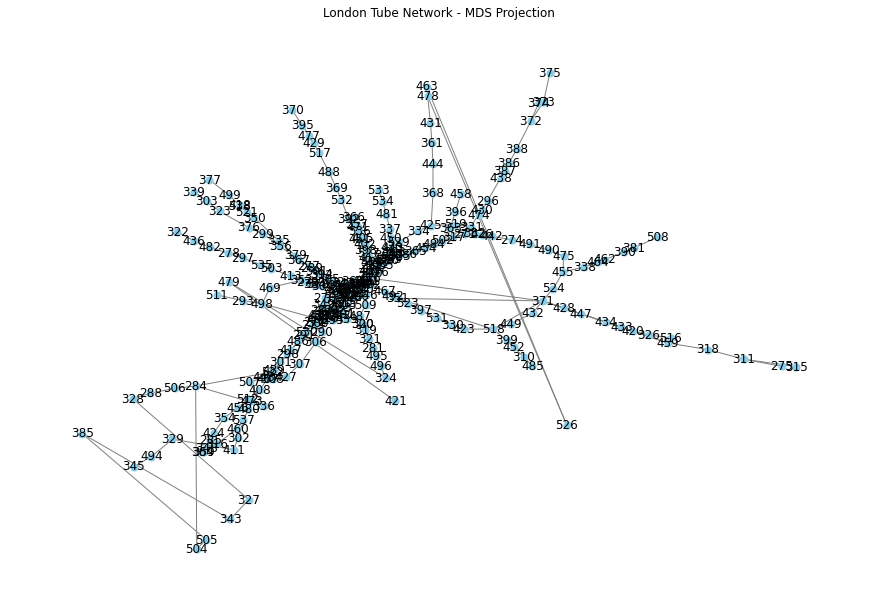

In [ ]:
from sklearn.manifold import MDS

# Convert the distance matrix to a 2D array
distance_array = distance_df.values

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(distance_array)

# Create a DataFrame for the MDS coordinates
mds_df = pd.DataFrame(mds_coordinates, columns=['MDS1', 'MDS2'], index=distance_df.index)


# Plot the MDS results as a network
plt.figure(figsize=(12, 8))

# Convert MDS DataFrame to a dictionary of positions
mds_positions = {str(node): (row['MDS1'], row['MDS2']) for node, row in mds_df.iterrows()}

# Draw the network using the MDS coordinates
nx.draw(
    G, 
    pos=mds_positions,  # Use MDS coordinates as positions
    with_labels=True, 
    node_size=50, 
    node_color='skyblue', 
    edge_color='gray'
)

plt.title("London Tube Network - MDS Projection")
plt.show()

In some way, the result can be seen as an attempt to reconstruct the attributes longitude and latitude via first and second MDS coordinate from the nodes pairwise distances. As however the precise geographical positions of the nodes are known already through their longitude and latitude, MDS appears not to be able to add significant insights.

### Centrality Measures 

__Log Scale__: Log scale doesnt help

Dont use OLS bcause Errors not heteroestadistic -> Weighted LS 

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            WLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     161.7
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           5.35e-05
Time:                        11:03:36   Log-Likelihood:                 2.7981
No. Observations:                   7   AIC:                            -1.596
Df Residuals:                       5   BIC:                            -1.704
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3029      0.109     30.217      0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


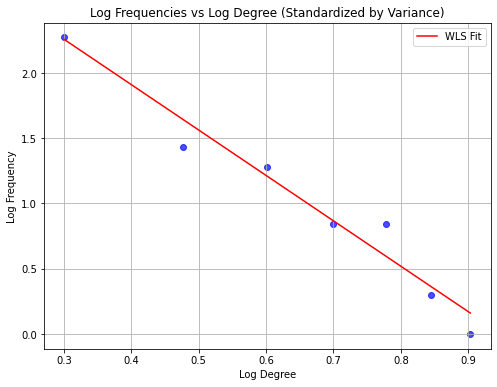

In [ ]:
import statsmodels.api as sm  # Import statsmodels

# Calculate the frequency of each degree
unique_degrees, counts = np.unique(degree_sequence, return_counts=True)

unique_degrees = unique_degrees[1:]
counts = counts[1:]

# Convert to log scale
log_degrees = np.log10(unique_degrees)
log_counts = np.log10(counts)

# Estimate variance as 1/counts
variances = 1 / counts

# Add a constant to the log_degrees for the intercept
log_degrees_with_const = sm.add_constant(log_degrees)

# Apply a linear model using weighted least squares with variance as weights
weights = 1 / variances  # Use the inverse of the variance as weights
model = sm.WLS(log_counts, log_degrees_with_const, weights=weights)
results = model.fit()

# Print the summary of the model
print(results.summary())

# Create the point plot
plt.figure(figsize=(8, 6))
plt.scatter(log_degrees, log_counts, color='blue', alpha=0.7)
plt.plot(log_degrees, results.predict(log_degrees_with_const), color='red', label='WLS Fit')

plt.title("Log Frequencies vs Log Degree (Standardized by Variance)")
plt.xlabel("Log Degree")
plt.ylabel("Log Frequency")
plt.grid(True)
plt.legend()
plt.show()


unique_degrees

__Closeness Centrality__

sum all distances between one node and all others and 1/sum -> small distances yield large closeness measure

Top 5 stations with highest closeness centrality:
Station: Oxford Circus (ID: 440), Closeness Centrality: 0.0637
Station: Green Park (ID: 362), Closeness Centrality: 0.0633
Station: Bond Street (ID: 294), Closeness Centrality: 0.0630
Station: Baker Street (ID: 280), Closeness Centrality: 0.0626
Station: Piccadilly Circus (ID: 445), Closeness Centrality: 0.0626


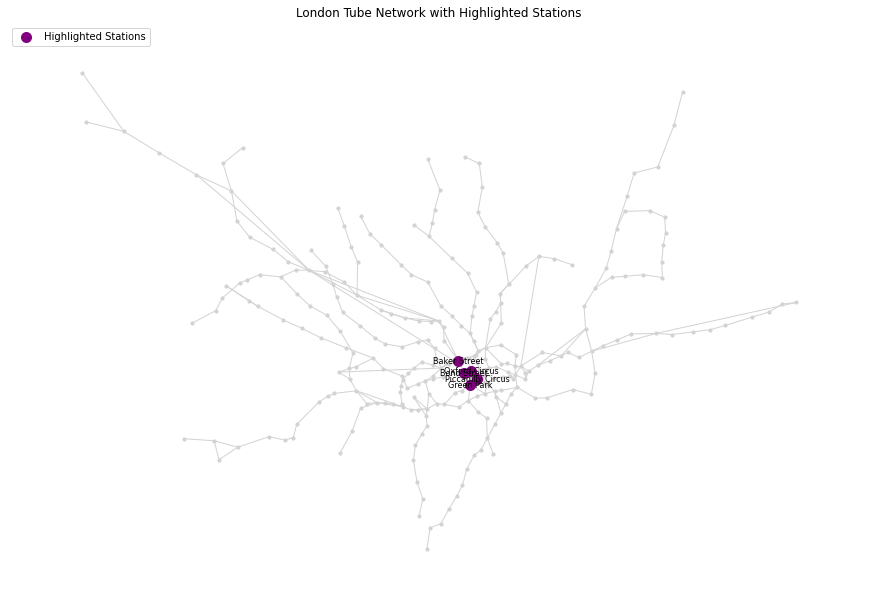

In [ ]:
# Calculate closeness centrality for all nodes
closeness_centrality = nx.closeness_centrality(G, distance='dist')

# Sort nodes by closeness centrality in descending order
top_closeness_stations = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Display the top 5 stations with their closeness centrality
print("Top 5 stations with highest closeness centrality:")
for node, centrality in top_closeness_stations:
    station_name = labels.get(node, "Unknown Station")
    print(f"Station: {station_name} (ID: {node}), Closeness Centrality: {centrality:.4f}")

top_closeness_ids = [station[0] for station in top_closeness_stations]
plot_highlighted_stations(G, pos_geo, top_closeness_ids, labels)